# AF\_plot\_Chelsea_

notebook to just plot the real LC and simulated LC (w/o  LSST), since we want uniform type of plots for both (including SDSS-PS1).

In [1]:
import matplotlib.lines as mlines
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import pandas as pd
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

Contents :<a id='contents'></a> 

* [Read Celerite real, Chelsea r-band , xmatch, save ](#read_celerite_chelsea)
* [Celerite: real LC  plot SDSS vs SDSS-PS1](#celerite_sdss-ps1)
* [Chelsea single-band](#readChelsea1)
* [DBQSO vs Shen2008: M_i](#dbqso_vs_shen08)
* [DBQSO vs Shen2011: M_i_corr](#dbqso_vs_shen11)
* [Shen2008 vs 2011 vs Paris2018](#ShenVsShen)
* [Chelsea : rest frame or observed ?](#restFramevsObserved)
* [Chelsea & Celerite : plot differences](#chelsea_vs_celerite)
* [Chelsea : Fig.3:  rest-frame tau vs SFinf](#ChelseaFig3)
* [Chelsea : Fig.12: QSO correlations](#ChelseaFig12)
* [Chelsea multi-band and Shen+2011 : Fig13 : wavelength dependence of $\tau$, SF](#readChelseaAll)
* [Chelsea multi-band Fig14](#ChelseaFig14)
* [Celerite Fig.14](#celeriteFig14)

## Read in Celerite real and Chelsea single band, save as AstroPy tables ,  xmatch to save as one table for plotting .... <a id='read_celerite_chelsea'></a>
[Contents](#contents)  

In [98]:
# PRE-PROCESS the Celerite results from numpy dic --> astropy table
# and Chelsea results from a dat w/o SFinf --> astropy table 

# read in the results of just fitting the real LCs 
fname = '190228_Celerite_real_Jeff1.npy'
r = np.load(fname).item()

# convert a dict to a table, choosing relevant parts... 
seg = list(r.keys())

d1 = pd.DataFrame.from_dict(r[seg[0]])
t1 = Table.from_pandas(d1)

d2 = pd.DataFrame.from_dict(r[seg[1]])
t2 = Table.from_pandas(d2)

celerite =  join(t1,t2, keys='lcname', table_names=[seg[0] ,seg[1]])
tall = t12

# add a column with int  DR7  dbID  for SDSS QSO 
dbID = np.asarray([x[:-4] for x in celerite['lcname']]).astype(int)
celerite['dbID']  = dbID

# add the info about qso from DR7 catalog to have ra, dec 
#  SDSS S82  9258  DR7 QSOs from Shen+2008
# from http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dr7 = Table.read(File, format='ascii', names = colnames)
celerite_dbqso = join(celerite, dr7, keys='dbID')

name = fname[:-4]+'_radec.txt'
celerite_dbqso.write(name, format='ascii', overwrite=True) 
print('Saved as ', name)

# read in Chelsea's results ... 
s82drw = Table.read('s82drw_r.dat', format='ascii',
                   names = ['SDR5ID', 'ra','dec', 'redshift', 'M_i', 'mass_BH',
                            'chi2_pdf', 'log10tau', 'log10sigmahat',
                            'log10tau_lim_lo','log10tau_lim_hi',
                            'log10sigmahat_lim_lo','log10sigmahat_lim_hi',
                            'edge', 'Plike', 'Pnoise', 'Pinf', 'mu', 'Npts'])
# add a column with SFinf in mags 
# sigmahat  =  SFinf / sqrt(tau)
# but she did it for tau in years ,
# so need to convert to days 
s82drw['SFinf'] = np.power(10,s82drw['log10sigmahat']) * np.sqrt(np.power(10,s82drw['log10tau']) / 365.)
s82drw.write('s82drw_r_table.txt', format='ascii', overwrite='True')


# Read in Chelsea's r-band results 
# And Celerite real LC results,
# cross-matched with DB_QSO_DR7  for ra,dec 
#celerite = Table.read('190228_Celerite_real_Jeff1_2000_table_radec.txt', format='ascii')
#chelsea = Table.read('s82drw_r_table.txt', format='ascii')
celerite = celerite_dbqso
chelsea = s82drw

# cross-match Celerite to Chelsea 
cat1 = SkyCoord(ra=celerite['ra']*u.degree, 
                dec=celerite['dec']*u.degree)
cat2 = SkyCoord(ra=chelsea['ra']*u.degree,
                dec=chelsea['dec']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
s82 = hstack([celerite, chelsea[idx]])
name = fname[:-4]+'_radec_s82drw_r.txt'
s82.write(name, format='ascii')
print('Saved cross-matched Celerite and Chelsea s82drw r-band as ', name)


Saved as  190228_Celerite_real_Jeff1_radec.txt
Saved cross-matched Celerite and Chelsea s82drw r-band as  190228_Celerite_real_Jeff1_radec_s82drw_r.txt


## Read in Celerite results <a id='readCelerite'></a>
[Contents](#contents) 

In [22]:
# read a dictionary with fit results ...
# note that for EXP prior doesn't really matter, 
# although I think that Jeff1 is more appropriate... (???)

#prior = 'Jeff2' ; date = '181128'  # running in iPython
prior = 'Jeff1' ; date='190228' # date = '190224'
#fname = date + '_Celerite_sim_and_real_'+prior+'.npy' # full results 
#fname = date + '_Celerite_sim_and_real_'+prior+'.npy' # full results 
fname = '190228_Celerite_real_Jeff1_1000.npy'
r = np.load(fname).item()

'_1000'

In [30]:
fname[:-4]

'190228_Celerite_real_Jeff1_1000'

In [ ]:
# Here I ran only SDSS, SDSS+PS1,  because those are the one we would eventually 
# keep.... I can later run a fit including SDSS+PS1+PTF  ,  SDSS+PS1+CRTS , etc .... 
# they can be saved separately - it's just that right now I was making a shortcut by 
# running a loop  with a following pseudocode : 
#
# for lc in lc_names  : 
#   for datatype in ['simul# convert a dict to a table, choosing relevant parts... 

seg = list(r.keys())

d1 = pd.DataFrame.from_dict(r[seg[0]])
t1 = Table.from_pandas(d1)

d2 = pd.DataFrame.from_dict(r[seg[1]])
t2 = Table.from_pandas(d2)

t12 =  join(t1,t2, keys='lcname', table_names=[seg[0] ,seg[1]])
tall = t12
name = fname[:-4]+'_table.txt'
tall.write(name, format='ascii',
              overwrite=True)
    print('Saved as ', name)ated', 'real'] : 
    #   for survey in [sdss,  sdss-ps1]
    #     if  lc['survey'] is in survey.split() : 
    #       fit lc[survey]
    #
# so each lc is first fit just for SDSS part, then for SDSS-PS1 part 

In [25]:
d1 = pd.DataFrame.from_dict(r[seg[1]])
t1 = Table.from_pandas(d1)
t1

lcname,length,sigmaEXP,sigmaMAP,tauEXP,tauMAP
str11,float64,float64,float64,float64,float64
1441903.txt,5057.300940000001,0.1870594482398289,0.1621964635082407,658.5722823842124,329.0304568988809
908716.txt,5207.878073,0.1316616540843225,0.11589644098964494,465.3892684037502,265.14502704165125
100520.txt,4009.163719999997,0.33787252120718586,0.33146578542409744,1.0080506510120386,1.0
3759755.txt,5226.883189,0.09556916191214068,0.0899303496646599,55.94990198052966,38.84249875597046
505877.txt,4698.1547809999975,0.0883076964545301,0.08299175858508001,2.926656915628973,1.0
248292.txt,5143.117292000003,0.28312134014855855,0.233722852251397,2167.2266663462424,1211.3467985608954
1225760.txt,5207.873875999998,0.32255534026807714,0.27720164648369156,708.2659483657949,346.22040279715264
953706.txt,5143.101957999999,0.07334025083491384,0.07043495061786205,29.993157212756394,12.730210779475295
3537034.txt,4446.075539999998,0.11558866020616972,0.10743698183519801,63.2490134370489,42.72162022597375


In [9]:

# convert a dict to a table, choosing relevant parts... 
for sim in r.keys():#  sim = 'real'#'simulated' # 'real 
    seg = list(r[sim].keys())

    d1 = pd.DataFrame.from_dict(r[sim][seg[0]])
    t1 = Table.from_pandas(d1)

    d2 = pd.DataFrame.from_dict(r[sim][seg[1]])
    t2 = Table.from_pandas(d2)

    t12 =  join(t1,t2, keys='lcname', table_names=[seg[0] ,seg[1]])


    if len(seg) == 2 :   # using sdss,  sdss=ps1 segments 
        tall = t12

    if len(seg) == 4 : # using sdss, sdss-ps1,  sdss-ps1-ptf,  
        #  sdss-ps1-ptf-crts segments .... 
        d3 = pd.DataFrame.from_dict(r[sim][seg[2]])
        t3 = Table.from_pandas(d3)

        d4 = pd.DataFrame.from_dict(r[sim][seg[3]])
        t4 = Table.from_pandas(d4)

        t34  = join(t2,t4,keys='lcname', table_names=[seg[2], seg[3]])
        tall = join(t12, t34, keys='lcname')


    # store the cross-matched table ... 
    name = fname[:16]+sim + fname[-10:-4]+'.txt'
    tall.write(name, format='ascii',
              overwrite=True)
    print('Saved as ', name)
    

Saved as  190224_Celerite_real_Jeff1.txt
Saved as  190224_Celerite_simulated_Jeff1.txt


In [ ]:

# convert a dict to a table, choosing relevant parts... 

seg = list(r.keys())

d1 = pd.DataFrame.from_dict(r[seg[0]])
t1 = Table.from_pandas(d1)

d2 = pd.DataFrame.from_dict(r[seg[1]])
t2 = Table.from_pandas(d2)

t12 =  join(t1,t2, keys='lcname', table_names=[seg[0] ,seg[1]])
tall = t12

## Plot Celerite real LC SDSS  vs SDSS-PS1 <a id='celerite_sdss-ps1'></a>
[Contents](#contents)  

Plot the difference between sigma, tau as inferred from just SDSS vs SDSS-PS1 : 

In [36]:
fname = '190228_Celerite_real_Jeff1_radec_s82drw_r.txt'
tall = Table.read(fname, format='ascii')

Text(0.5, 0.98, 'sim DRW , EXP')

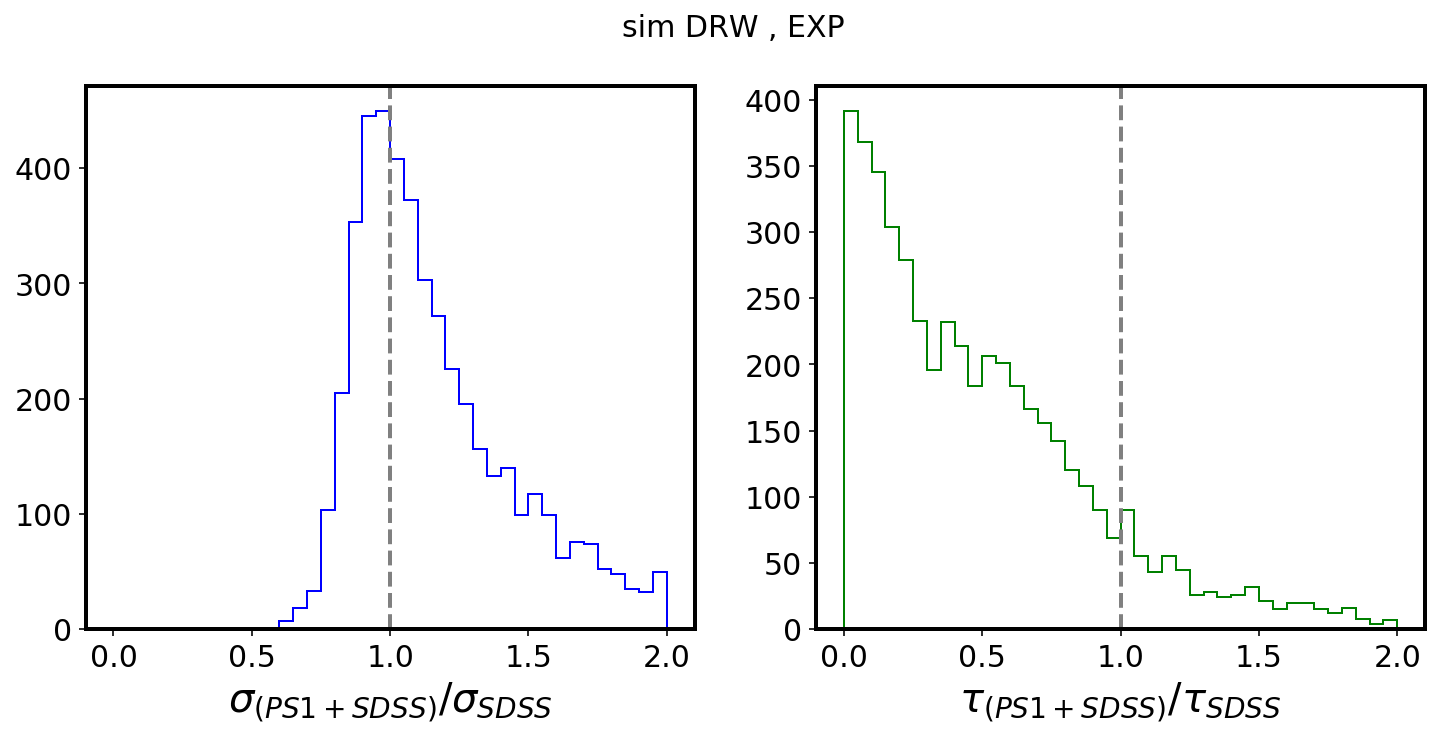

In [38]:
%matplotlib inline

# Choose what to plot : which  file, (prior, date)
# whether real or simulated,  
# and whether MAP or EXP 
#sim = 'real'# 'simulated'#'real'# 'simulated'
#date = '190224' ; prior = 'Jeff1'
#tall = Table.read(date + '_Celerite_'+sim+'_'+prior+'.txt', format='ascii')
fit = 'EXP'#'MAP'# 'EXP'
sim='real'

# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 


fig,ax = plt.subplots(1,2, figsize=(12,5))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []

i = 0

labels = {'sigma': r'$\sigma_{(PS1+SDSS)} / \sigma_{SDSS}$',
         'tau':r'$\tau_{(PS1+SDSS)} / \tau_{SDSS}$'}


for q in ['sigma','tau']:
    # selection : 
    m = (tall['tau'+fit+'_sdss-ps1'] > 5) & (tall['tau'+fit+'_sdss'] > 5) 
    
    # plot 
    x = tall[q+fit+'_sdss-ps1'][m] /  tall[q+fit+'_sdss'][m]
    ax[i].hist(x , histtype='step', 
               bins=40, range=[0,2], color = colors[i]) 
    ax[i].set_xlabel(labels[q])
    #line = mlines.Line2D([], [],  color=colors[i], label=s)
    #ax_legend_handles.append(line)
    i += 1 
 
    
#ax[0].legend(loc='upper right', handles = ax_legend_handles,
#             bbox_to_anchor=(1.0, 1.0),
#             ncol=1, fancybox=True, shadow=True ) 
             
ax[0].axvline(1, lw=2, ls='--', c='grey')
ax[1].axvline(1, lw=2, ls='--', c='grey')

fig.suptitle(sim + ' DRW , '+ fit , fontsize = 15)
#plt.savefig(sim + 'DRW_'+prior+fit+'.png', bbox_inches="tight")

So this comparison doesn't bring me much, because  I don't have a way of excluding the QSO for which the fitted timescale is too close to the SDSS baseline (and definitely not 10 times less...). For how many cases fitted timescale is at least ten times less than the SDSS baseline, and SDSS-PS1 baseline....

In [154]:
print('Number of qso for which timescale is at least\
ten times shorter than the total LC baseline for ')
for s in ['sdss','sdss-ps1']:
    m = 10* tall['tauEXP_'+s] <  tall['length_'+s]
    print(s, ' is  ', np.sum(m))


Number of qso for which timescale is at leastten times shorter than the total LC baseline for 
sdss  is   948
sdss-ps1  is   1920


Only 663 for only SDSS... Less than 10% of the sample. And 4113 for PS1. This may mean that with SDSS only many timescales are unconstrained... But compare these to Chelsea's results : 

## Read in MacLeod+2010 results <a id='readChelsea'></a> 

Grab the DRW fit params from http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html

Use the r-band ... 

In [2]:
s82drw = Table.read('s82drw_r.dat', format='ascii',
                   names = ['SDR5ID', 'ra','dec', 'redshift', 'M_i', 'mass_BH',
                            'chi2_pdf', 'log10tau', 'log10sigmahat',
                            'log10tau_lim_lo','log10tau_lim_hi',
                            'log10sigmahat_lim_lo','log10sigmahat_lim_hi',
                            'edge', 'Plike', 'Pnoise', 'Pinf', 'mu', 'Npts'])
# her selection (chapter 3, macleod2010) was to use only those 
# where 
m1 = s82drw['Npts'] > 10 
print(np.sum(m1))
m2 = s82drw['Plike'] - s82drw['Pnoise'] > 2 
print(np.sum(m2))
m3 = s82drw['Plike'] - s82drw['Pinf'] > 0.05 
print(np.sum(m3))
m4 = s82drw['edge'] == 0 
print(np.sum(m4))
print(np.sum(m1&m2&m3&m4))

# add a column with SFinf in mags 
# sigmahat  =  SFinf / sqrt(tau)
# but she did it for tau in years ,
# so need to convert to days 
s82drw['SFinf'] = np.power(10,s82drw['log10sigmahat']) * np.sqrt(np.power(10,s82drw['log10tau']) / 365.)


9139
9128
7103
7823
6871


Saved as  190228_Celerite_real_Jeff1_1000_table.txt
9139
9128
7103
7823
6871


In [4]:
# those newly discovered that were not in DR5...
np.sum(s82drw['SDR5ID'] < 0)

301

In [3]:
# read in Shen+2007 to check which M_i she's storing in the s82drw* catalog ...
#allegedly it's the corrected M_i, but now I'm not too sure ... 
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
shen2007 = Table.read(File, format='ascii', names = colnames)




In [4]:
#cross-match....
cat1 = SkyCoord(ra=s82drw['ra']*u.degree, 
                dec=s82drw['dec']*u.degree)
cat2 = SkyCoord(ra=shen2007['ra']*u.degree,
                dec=shen2007['dec']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
#['d2d_arcsec_DR7']=sep2d.value*3600

t = hstack([s82drw, shen2007[idx]])


In [6]:
# Add Shen2011 to verify that DB_QSO  M_i_corr is the same as MI_Z2   

shen2011 = Table.read("dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
m = shen2011[abs(shen2011['DEC']) < 1.5]
sel = m[['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO', 'MI_Z2' ]]

# cross-match 
cat1 = SkyCoord(ra=t['ra_1']*u.degree, 
                dec=t['dec_1']*u.degree)
cat2 = SkyCoord(ra=sel['RA']*u.degree,
                dec=sel['DEC']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
tt = hstack([t, sel[idx]])

In [9]:
tt['M_i_1', 'M_i_2', 'M_i_corr', 'MI_Z2']

M_i_1,M_i_2,M_i_corr,MI_Z2
float64,float64,float64,float64
-23.901,-23.901,-24.181,-24.28560773968867
-23.399,-23.399,-23.576,-23.96421289067481
-24.735,-24.735,-25.058,-25.008960685706665
-23.121,-23.121,-24.045,-24.03915568655799
-26.451,-26.451,-26.974,-26.916981368954627
-24.917,-24.917,-25.288,-25.23082414221863
-27.263,-27.263,-27.856,-27.80633729514747
-24.427,-24.427,-24.898,-24.738376414675884
-25.251,-25.251,-25.695,-25.535346152682955


In [11]:
np.median(tt['M_i_corr'] - tt['MI_Z2'])

-0.03411262251343139

(array([  3.,   5.,   3.,   9.,  17.,  26.,  36.,  74., 110., 153., 222.,
        320., 408., 507., 608., 667., 746., 763., 800., 697., 612., 510.,
        460., 367., 289., 225., 212., 181., 124.,  92.,  11.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-30.  , -29.75, -29.5 , -29.25, -29.  , -28.75, -28.5 , -28.25,
        -28.  , -27.75, -27.5 , -27.25, -27.  , -26.75, -26.5 , -26.25,
        -26.  , -25.75, -25.5 , -25.25, -25.  , -24.75, -24.5 , -24.25,
        -24.  , -23.75, -23.5 , -23.25, -23.  , -22.75, -22.5 , -22.25,
        -22.  , -21.75, -21.5 , -21.25, -21.  , -20.75, -20.5 , -20.25,
        -20.  ]),
 <a list of 1 Patch objects>)

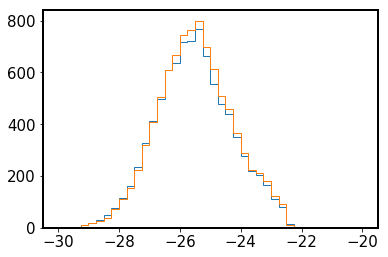

In [15]:
%matplotlib inline
plt.hist(tt['M_i_corr'], histtype='step', range=(-30,-20), bins=40)
plt.hist(tt['MI_Z2'], histtype='step',range=(-30,-20), bins=40)

This shows that Shen+2008 (which is in DB_QSO)  M_i_corr (K-corrected to z=2), and Shen+2011 (a newer catalog) MI_Z2 (also K-corrected to z=2) are the same. So definitely **DB_QSO M_i_corr is  K-corrected to z=2 !!! **

## Add DR5  Shen+2008 catalog

--> the same info as in Chelsea's results , unneccesary if already adding DR7 Shen+2011 data
--> Note: on the website http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern_format_DB.html it's a misnomer as while it's called "qso_dr7" these are really dr7 quasars with Shen+2008 DR5 data. This means that the DR7 QSO that did not have Shen+2008 (DR5) data, have a value of "-1" for eg. bolometric luminosity or black hole mass...

--> I still add it here because 

   a) Chelsea uses it in her MacLeod+2010 paper  and I want to be able to reproduce her results 
   
   b) I want to know how much of a change in results (slopes , etc.) is merely because of differences in Lbol, MBH  between Shen+2008 vs Shen+2011,  and how much is because the parameters themselves have different values ... 

-

In [797]:
len(celerite)

6444

In [580]:
#Results of Celerite fit for real combined light curves
sim = 'real' 
celerite = Table.read('181128_Celerite_'+sim+'_Jeff2.txt', format='ascii')

# add a column with int  DR7  dbID  for SDSS QSO 
dbID = np.asarray([x[:-4] for x in tall['lcname']]).astype(int)
celerite['dbID']  = dbID


# add the info about qso from DR7 catalog 
# to have ra, dec 
#  SDSS S82  9258  DR7 QSOs from Shen+2008
# from http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dbqso = Table.read(File, format='ascii', names = colnames)
celerite_dbqso = join(celerite, dr7, keys='dbID')


### Add DR7 Shen+2011 catalog ... 
[contents](#contents)

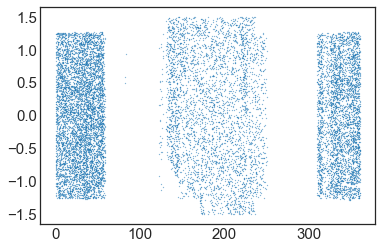

In [947]:
#Ok, so here's Shen+2011 catalog from # 
#http://das.sdss.org/va/qso_properties_dr7/dr7.htm#updates  : 

# these are all SDSS QSOs ... 
cat = Table.read("dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
cat_ = cat[abs(cat['DEC']) < 1.5]
plt.scatter(cat_['RA'], cat_['DEC'], s=0.05)
cat_sel = cat_[['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO', 'MI_Z2' ]]

In [817]:
cat.colnames

['SDSS_NAME',
 'RA',
 'DEC',
 'REDSHIFT',
 'PLATE',
 'FIBER',
 'MJD',
 'TARGET_FLAG_TARGET',
 'NSPECOBS',
 'UNIFORM_TARGET',
 'MI_Z2',
 'LOGLBOL',
 'LOGLBOL_ERR',
 'BAL_FLAG',
 'FIRST_FR_TYPE',
 'FINT_REST6CM_MJY_OBS',
 'LOGFNU2500A_ERGS_OBS',
 'R_6CM_2500A',
 'LOGL5100',
 'LOGL5100_ERR',
 'LOGL3000',
 'LOGL3000_ERR',
 'LOGL1350',
 'LOGL1350_ERR',
 'LOGL_BROAD_HA',
 'LOGL_BROAD_HA_ERR',
 'FWHM_BROAD_HA',
 'FWHM_BROAD_HA_ERR',
 'EW_BROAD_HA',
 'EW_BROAD_HA_ERR',
 'LOGL_NARROW_HA',
 'LOGL_NARROW_HA_ERR',
 'FWHM_NARROW_HA',
 'FWHM_NARROW_HA_ERR',
 'EW_NARROW_HA',
 'EW_NARROW_HA_ERR',
 'LOGL_NII_6585',
 'LOGL_NII_6585_ERR',
 'EW_NII_6585',
 'EW_NII_6585_ERR',
 'LOGL_SII_6718',
 'LOGL_SII_6718_ERR',
 'EW_SII_6718',
 'EW_SII_6718_ERR',
 'LOGL_SII_6732',
 'LOGL_SII_6732_ERR',
 'EW_SII_6732',
 'EW_SII_6732_ERR',
 'EW_FE_HA',
 'EW_FE_HA_ERR',
 'ALPHA_HA',
 'ALPHA_HA_ERR',
 'LINE_NPIX_HA',
 'LINE_MED_SN_HA',
 'LINE_REDCHI2_HA',
 'LOGL_BROAD_HB',
 'LOGL_BROAD_HB_ERR',
 'FWHM_BROAD_HB',
 'FWHM_BRO

In [818]:
# Considering QSO that have very different 
# black hole measurements between Shen+2008 and 2011...
m1 = qso['mass_BH'] > 0
m2 = abs(qso['mass_BH']- qso['LOGBH']) > 2
names=  qso[m1*m2]['SDSS_NAME']
cat[np.in1d(cat['SDSS_NAME'], names)]['SDSS_NAME', 'PLATE', 'FIBER', 
                                     'LOGLBOL', 'LOGBH_HB_MD04',
 'LOGBH_HB_MD04_ERR','LOGBH_HB_VP06','LOGBH_HB_VP06_ERR', 
            'LOGBH_MGII_MD04','LOGBH_MGII_MD04_ERR',
 'LOGBH_MGII_VO09','LOGBH_MGII_VO09_ERR','LOGBH_MGII_S10',
 'LOGBH_MGII_S10_ERR', 'LOGBH_CIV_VP06', 'LOGBH_CIV_VP06_ERR',
 'LOGBH','LOGBH_ERR', 'LOGEDD_RATIO',]

SDSS_NAME,PLATE,FIBER,LOGLBOL,LOGBH_HB_MD04,LOGBH_HB_MD04_ERR,LOGBH_HB_VP06,LOGBH_HB_VP06_ERR,LOGBH_MGII_MD04,LOGBH_MGII_MD04_ERR,LOGBH_MGII_VO09,LOGBH_MGII_VO09_ERR,LOGBH_MGII_S10,LOGBH_MGII_S10_ERR,LOGBH_CIV_VP06,LOGBH_CIV_VP06_ERR,LOGBH,LOGBH_ERR,LOGEDD_RATIO
bytes18,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
005722.30+001644.6,1083,472,46.4964211199,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-999.0
013347.57-002312.6,1078,201,45.8307757096,0.0,-1.0,0.0,-1.0,9.30652534673,0.149084136963,8.24926632148,0.316816029022,0.0,-1.0,0.0,-1.0,0.0,-1.0,-999.0
023011.28+005913.6,1509,365,46.8487357602,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-999.0
204446.24-004601.8,1116,284,46.592303212,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-999.0
204950.47-004653.7,1116,59,46.7235365352,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-999.0
210750.44-002436.5,985,174,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-999.0
223925.92+000340.3,1901,318,44.6712777855,0.0,-1.0,0.0,-1.0,7.0350294075,0.04233303526,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-999.0


In [906]:
len(celerite_dbqso)

6444

In [948]:
# crossmatch Celerite+DR5 with DR7 
# http://iopscience.iop.org/article/10.1086/518474/pdf Schneider+2007 
cat1 = SkyCoord(ra=celerite_dbqso['ra']*u.degree, 
                    dec=celerite_dbqso['dec']*u.degree)
cat2 = SkyCoord(cat_sel['RA']*u.degree,cat_sel['DEC']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
celerite_dbqso['d2d_arcsec_DR7']=sep2d.value*3600

qso = hstack([celerite_dbqso, cat_sel[idx]])

qso[['redshift', 'mass_BH', 'LOGBH', 'Lbol','LOGLBOL', 'REDSHIFT',
     'LOGEDD_RATIO','SDSS_NAME']][:5]

redshift,mass_BH,LOGBH,Lbol,LOGLBOL,REDSHIFT,LOGEDD_RATIO,SDSS_NAME
float64,float64,float64,float64,float64,float64,float64,bytes18
1.6199,0.0,8.92171816669,0.0,45.9522119138,1.6209000349,-1.069876798,000119.50+001038.0
0.6125,0.0,9.02221107204,45.433,45.3939103924,0.612399995327,-1.72867122474,000527.52-000556.2
1.3988,8.817,8.77970169839,46.071,46.0356964494,1.39900004864,-0.844375794117,000107.52+004113.1
2.8473,0.0,9.16110841789,0.0,46.8489459039,2.85730004311,-0.412533059113,001025.90+005447.6
1.3383,8.666,8.58543659024,45.862,45.8401451621,1.3370000124,-0.84566197325,000640.67+003838.2


## Compare Schneider+2007 (Shen+2008) with DBQSO : 'M_i' is k-corrected to z=0  <a id='dbqso_vs_shen08'></a>
[contents](#contents)

In [9]:
# Read in Schneider+2007 table
dr5 = np.genfromtxt('dr5qso.dat', skip_header=80, usecols=(1,2,31),
                   names=['ra','dec', 'M_i']) # M_i is most likely K-corrected to z=0 
sch = Table(dr5)

# read in DBQSO ... 
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dbqso = Table.read(File, format='ascii', names = colnames)



In [27]:
# crossmatch  only those from DB_QSO that were in DR5...
sel= dbqso[dbqso['M_i_corr'] < -1 ] 
print('Of ', len(dbqso), ' quasars in DB_QSO, ', len(sel) , ' were from DR5')

# dbqso -->  Shen2008/Schneider2007
cat1 = SkyCoord(ra=sel['ra']*u.degree, dec=sel['dec']*u.degree)
cat2 = SkyCoord(sch['ra']*u.degree, sch['dec']*u.degree, frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
sel['d2d_arcsec_DR5']=sep2d.value*3600

combined = hstack([sel, sch[idx]])

combined[:5]

Of  9258  quasars in DB_QSO,  8957  were from DR5


dbID,ra_1,dec_1,SDR5ID,M_i_1,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,d2d_arcsec_DR5,ra_2,dec_2,M_i_2
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
70,2.169302,1.238649,301,-23.901,-24.181,1.073,0.0,0.0,20.793,20.469,20.197,20.04,20.0,0.116,0.0,2.169302,1.238649,-23.901
98,1.091028,0.962126,144,-23.399,-23.576,0.7867,0.0,0.0,20.79,20.183,19.849,19.818,19.43,0.183,0.0,1.091028,0.962126,-23.399
233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,0.0,0.331289,0.17723,-24.735
1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,0.0,1.364696,-0.098956,-23.121
1310,0.221552,-0.292485,36,-26.451,-26.974,2.7563,9.361,46.76,20.707,19.663,19.61,19.705,19.529,0.174,0.0,0.221552,-0.292485,-26.451


In [28]:
len(combined)

8957

In [30]:
# compare M_i  in Schneider+2007 catalog and M_i  in DB_QSO...
# All agree to the dot ! 
np.where((combined['M_i_1'] - combined['M_i_2']) != 0 )

(array([], dtype=int64),)

## Compare Schneider+2010 (Shen+2011) with DBQSO : 'M_i_corr' is k-corrected to z=2 <a id='dbqso_vs_shen11'></a>
[contents](#contents)

In [3]:
# Read Shen2011 (who used Schneider2010 values for absolute magnitudes)
shen2011 = Table.read("dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and only names of relevance 
shen = shen2011[abs(shen2011['DEC']) < 1.5][['RA', 'DEC', 'MI_Z2' ,'REDSHIFT']]


# read in DBQSO ... 
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dbqso = Table.read(File, format='ascii', names = colnames)


# cross-match   dbqso -->  Shen2011/Schneider2010
cat1 = SkyCoord(ra=dbqso['ra']*u.degree, dec=dbqso['dec']*u.degree)
cat2 = SkyCoord(ra=shen['RA']*u.degree,dec=shen['DEC']*u.degree, frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 

dbqso['d2d_arcsec_shen2011'] = sep2d
comb  = hstack([dbqso, shen[idx]])

8957
7508
-0.03446714915716065
-0.035485035342261995


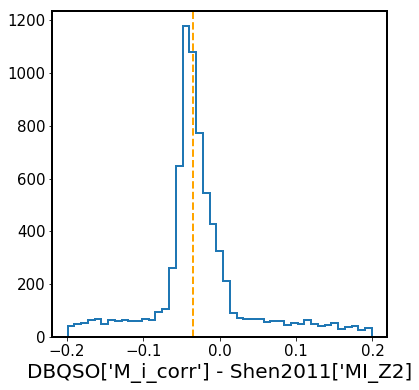

In [4]:
%matplotlib inline
# select those that had the correction  available ...
m = comb['M_i_corr'] < -1 
c = comb[m]
delta = c['M_i_corr'] - c['MI_Z2']
print(len(delta))
selection = abs(delta)<0.2
print(np.sum(selection))

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.hist(delta[selection], bins=45, histtype='step',lw=2)
ax.set_xlabel("DBQSO['M_i_corr'] - Shen2011['MI_Z2]")
ax.axvline(np.median(delta[selection]), lw=2,ls='--', c='orange')
print(np.median(delta[selection]))
print(np.median(delta))
plt.savefig('DBQSO-M_i_corr_vs_Shen2011-MI_Z2.png', bbox_inches='tight')

Showing the difference between DBQSO M_i_corr and Shen2011 'MI_Z2'. Both are claimed to have been k-corrected to z=2. Of 8957  quasars in DBQSO that have M_i_corr correction (i.e. not '-1' ),  for 7508  the difference from Shen2011 is less than 0.2 mag.  But the residuals are centered around -0.03 mag (median for shown subset). The median of residuals for entire dataset is  

### Compare values from Shen+2008 ( used by Chelsea in 2010), and those from Shen+2011 ... <a id='ShenVsShen'></a>
[contents](#contents)

Use also SDSS DR14 Quasar catalog from DR14 (Paris+2018) : there the values should be most accurate ... 
https://www.sdss.org/dr14/algorithms/qso_catalog/
https://arxiv.org/pdf/1712.05029.pdf
https://data.sdss.org/datamodel/files/BOSS_QSO/DR14Q/DR14Q_v4_4.html


In [899]:
location = '/Users/chris/GradTeaching/uw-astr598-w18/homeworks/group2/DR14Q_v4_4.fits'
dr14 = Table.read(location, format='fits')

In [912]:
dr14_ = dr14[abs(dr14['DEC']) < 1.5]

In [949]:
np.sum(np.in1d(qso['SDSS_NAME'], dr14_['SDSS_NAME']))

5178

In [960]:
# crossmatch Celerite+DR5, DR7 with DR14  
cat1 = SkyCoord(ra=qso['RA']*u.degree, 
                dec=qso['DEC']*u.degree)
cat2 = SkyCoord(ra=dr14_['RA'],
                dec=dr14_['DEC'], )
#                frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
qso['d2d_arcsec_DR14']=sep2d.value*3600

qso_ = hstack([qso, dr14_[idx]['SDSS_NAME','RA','DEC', 'THING_ID', 'Z', 'MI',]])

qso_ = qso_[qso_['d2d_arcsec_DR14'] < 0.5]

(array([  1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          6.31500000e+03,   5.70000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([-0.92445199, -0.6891168 , -0.45378161, -0.21844643,  0.01688876,
         0.25222395,  0.48755914,  0.72289433,  0.95822952,  1.1935647 ,
         1.42889989]),
 <a list of 10 Patch objects>)

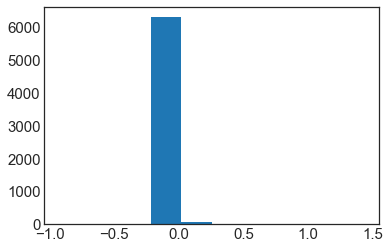

In [961]:
plt.hist(qso_['REDSHIFT'] - qso_['Z'])

In [968]:
qso_

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ptf,sigmaEXP_sdss-ps1-ptf,sigmaMAP_sdss-ps1-ptf,tauEXP_sdss-ps1-ptf,tauMAP_sdss-ps1-ptf,length_sdss-ps1-ptf-crts,sigmaEXP_sdss-ps1-ptf-crts,sigmaMAP_sdss-ps1-ptf-crts,tauEXP_sdss-ps1-ptf-crts,tauMAP_sdss-ps1-ptf-crts,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,d2d_arcsec_DR7,SDSS_NAME_1,RA_1,DEC_1,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,d2d_arcsec_DR14,SDSS_NAME_2,RA_2,DEC_2,THING_ID,Z,MI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-,deg,deg,-,-,-
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,int32,float64,float64
233.txt,3321.033842,0.112765414555,0.0898995121063,981.875197365,270.133423745,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.115511511771,0.113080341967,17.7186414587,12.1535796268,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,0.00718657465285,000119.50+001038.0,0.331288993359,0.17722800374,1.6209000349,45.9522119138,8.92171816669,0.204242161504,-1.069876798,-25.0089606857,1.99839188402e-13,000119.50+001038.0,0.331288993359,0.17722800374,-1,1.6209,-25.04644
1018.txt,3336.933302,0.219967338358,0.166799870973,1005.98831672,331.440202397,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.208861039395,0.205851702862,1.12644722505,1.0,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,0.0108218821638,000527.52-000556.2,1.36469900608,-0.0989559963346,0.612399995327,45.3939103924,9.02221107204,0.267494722292,-1.72867122474,-24.0391556866,0.0,000527.52-000556.2,1.36469900608,-0.0989559963346,-1,0.6124,-23.589289
1327.txt,3336.933324,0.10176772487,0.0824972045393,567.610084936,215.218303228,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5865.0169872,0.137629240634,0.13302700692,22.3107288091,17.5193899944,1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139,0.0210127501153,000107.52+004113.1,0.281367003918,0.68698900938,1.39900004864,46.0356964494,8.77970169839,0.100770668469,-0.844375794117,-25.2308241422,0.0,000107.52+004113.1,0.281367003918,0.68698900938,-1,1.399,-25.267258
1540.txt,3321.033885,0.097085050401,0.0829833542739,2833.63335653,2078.35617054,5141.047905,0.409454462022,0.403394414457,1.00355321529,1.0,5141.047905,0.409454462022,0.403394414457,1.00355321529,1.0,5859.0268622,0.349226747464,0.346859742043,1.00008007328,1.0,1540,2.607954,0.913245,370,-27.263,-27.856,2.8473,0.0,0.0,21.346,19.15,19.093,18.944,18.758,0.122,0.00695700118753,001025.90+005447.6,2.60795593262,0.913245022297,2.85730004311,46.8489459039,9.16110841789,0.0607332547083,-0.412533059113,-27.8063372951,0.0452186922424,001025.91+005447.6,2.607958662,0.913232761597,116665877,2.86,-27.780611
1580.txt,3336.933299,0.110542000348,0.0920232262927,406.837957723,155.445669783,5147.032184,0.0970246015486,0.089378878649,132.925722294,81.0653330761,5147.032184,0.0970246015486,0.089378878649,132.925722294,81.0653330761,5483.982094,0.126533555511,0.117356665191,139.474587967,84.2646981058,1580,1.669492,0.643952,229,-24.427,-24.898,1.3383,8.666,45.862,20.732,20.572,20.13,20.079,20.231,0.207,0.00496204394004,000640.67+003838.2,1.66949105263,0.643950998783,1.3370000124,45.84

54 objects for which absolute magnitude estimate is really off ... They also have different redshift extimate between Schneider+2010 and Paris+2018...  : 

In [965]:
qso_[abs(qso_['M_i_corr']-qso_['MI'])>2][['M_i','M_i_corr','MI', 'REDSHIFT', 'Z']]

M_i,M_i_corr,MI,REDSHIFT,Z
,,-,,-
float64,float64,float64,float64,float64
-24.963,-25.675,-45.755123,1.99679994583,1.9898037
-25.337,-25.816,-23.351093,2.21989989281,0.791
-23.969,-24.331,-44.493958,1.16939997673,1.1694
-24.188,-24.752,-44.286289,1.04330003262,1.0394117
-24.567,-25.091,-43.960838,0.872099995613,0.8721
-24.528,-24.956,-44.775505,1.33169996738,1.3306768
-22.69,-23.239,-20.965515,0.623000025749,0.6241851
-22.611,-23.069,-42.474098,0.481499999762,0.4815


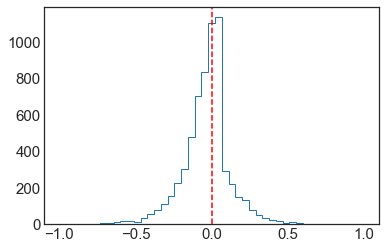

In [966]:
# Chelsea's catalog : M_i  "K-corrected absolute i band magnitude"  ( from Schneider+2007)
# and M_i_corr  "Absolute i band magnitude, k-corrected to z=2, taken from Shen+2008" 


# MI_Z2 :  "Absolute i-band magnitude (normalized at z=2), 
# K-corrected following Richards et al. (2006a)", from Shen+2011 

# MI : "The absolute magnitude in the i band at z = 2 calculated 
#  using a power-law (frequency) continuum index of −0.5. 
# The K- correction is computed using Table 4 from Richards et al. (2006)." 
# -->  item 43 of Paris+2018 DR14 

plt.hist(qso_['MI_Z2']-qso_['MI'], range=(-1,1), bins=45, histtype='step')
plt.axvline(0, ls='--', c='r')

In [967]:
plt.hist()

SDSS_NAME_1,SDSS_NAME_2
,-
bytes18,bytes18


In [917]:
dr14_[['RA','DEC']]

RA,DEC
deg,deg
float64,float64
0.005746209112,-1.32500880111
0.00646351624147,-0.559065870312
0.0068553910144,0.583183807035
0.00806669057969,-0.240970794399
0.0132289952098,1.2529671217
0.0136302532122,0.192448678687
0.0199430988304,-0.909634851183
0.0206958530495,-0.278343319588


So the overall distribution is self-similar, but is scattered considerably (note the log-log space! )
So in Lbol theres less scatter, but  1819  QSO did not have Lbol in DR5 (Shen+2008), but they all have that in DR7 (Shen+2011) 


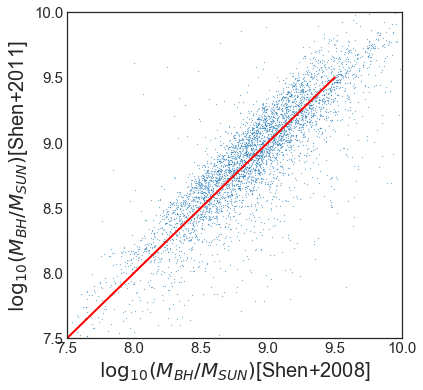

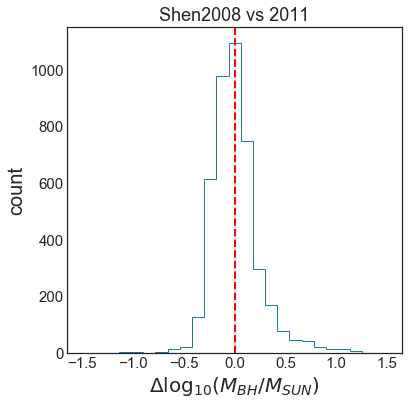

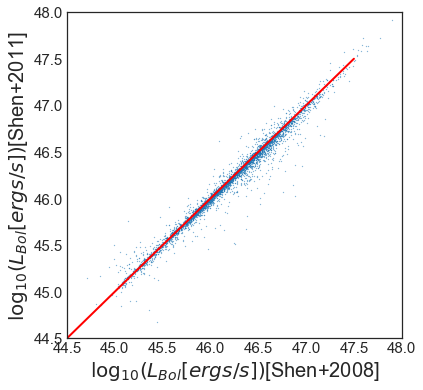

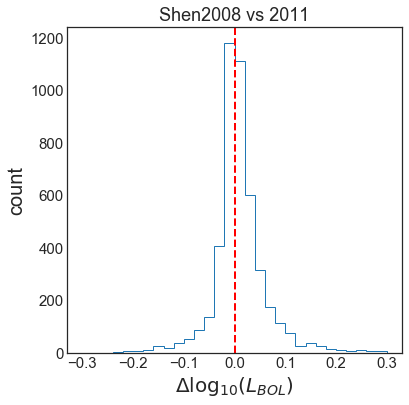

In [1017]:
# show the difference in BH measurements
# between Shen2008 and Shen2011 
plt.figure(figsize=(6,6))
plt.scatter(qso['mass_BH'], qso['LOGBH'], s=0.05)
l1,l2 = 7.5,10
plt.xlim(l1,l2)
plt.ylim(l1,l2)
x = np.arange(l1,l2)
plt.plot(x, x, c='red', lw='2')
plt.xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$'+
        '[Shen+2008]')
plt.ylabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$'+
        '[Shen+2011]')
print('So the overall distribution is self-similar, \
but is scattered considerably (note the log-log space! )')
plt.savefig('MBH_Shen2008_2011.png', bbox_inches='tight')


# plot the histogram 
plt.figure(figsize=(6,6))
m1 = qso['mass_BH'] > 0 # skip those QSO that did not have BH Masses in Shen 2008 ... 
m2 = qso['LOGBH'] > 0 # skip those that do not have reliable Shen+2011 measurements 
m = m1 &  m2 
plt.hist(qso['mass_BH'][m]- qso['LOGBH'][m], histtype='step',
        bins=25, range=(-1.5,1.5))
plt.xlabel(r'$\Delta \log_{10}{(M_{BH} / M_{SUN})}$')
plt.ylabel('count')
plt.axvline(0, ls='--', lw=2, c='r')
plt.title('Shen2008 vs 2011')
plt.savefig('MBH_Shen_2008_2011_hist.png', bbox_inches='tight')

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(qso['Lbol'], qso['LOGLBOL'], s=0.05)
l1,l2 = 44.5,48

x = np.arange(l1,l2)
ax.plot(x, x, c='red', lw='2')
ax.set_xlim(l1,l2)
ax.set_ylim(l1,l2)
ax.set_xlabel(r'$\log_{10}{(L_{Bol} [ergs/s])}$'+
        '[Shen+2008]')
ax.set_ylabel(r'$\log_{10}{(L_{Bol} [ergs/s])}$'+
        '[Shen+2011]')
plt.savefig('LBol_Shen2008_2011.png', bbox_inches='tight')
print('So in Lbol theres less scatter, but ', np.sum(qso['Lbol'] == 0 ), 
' QSO did not have Lbol in DR5 (Shen+2008), \
but they all have that in DR7 (Shen+2011) ')


plt.figure(figsize=(6,6))
m1 = qso['Lbol']  > 0 # remove those that do not have Lbol estimates in Shen+2008 
# and those that do not have these estimates for some reason in Shen+2011 
# ( it's only one QSO, ')210750.44-002436.5
m2 = qso['LOGLBOL'] > 0 
m = m1&m2
plt.hist(qso['Lbol'][m] - qso['LOGLBOL'][m], histtype='step', 
        bins=30, range=(-0.3,0.3))
plt.axvline(0, ls='--', lw=2, c='r')
plt.xlabel(r'$\Delta \log_{10}{(L_{BOL})}$')
plt.ylabel('count')
plt.title('Shen2008 vs 2011')
plt.savefig('Lbol_Shen_2008_2011_hist.png', bbox_inches='tight')





SDSS DR5 Quasar catalog is Schneider+2007 with redshifts, i-band absolute magnitude (MI) for which black hole masses were found in Shen+2008
SDSS DR7 Quasar catalog is Schneider+2010,  for which black hole masses are in Shen+2011. 
The latest SDSS DR14 Quasar catalog is Paris+2018,  and I don't know  if there are any updates to black hole mass.

Now, apart from updated black hole masses, there is also a difference in redshift estimates. For that, there is Schneider+2007,2010, and Paris+2018.
Another parameter is  the absolute K-corrected i-band magnitude , normalized to z=2 (MI_Z2) . That quantity is included in Shen2008,2011, and Paris2018,  but it's not clear to me whether Chelsea used MI  or MI_Z2  for her plots. 

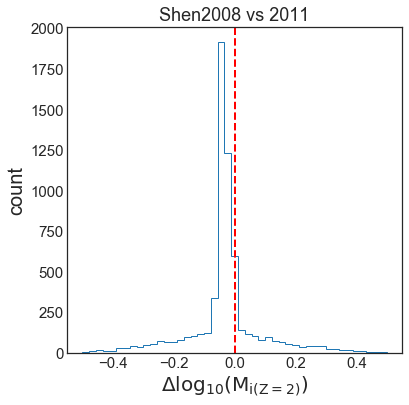

In [1018]:
plt.figure(figsize=(6,6))

plt.hist(qso_['M_i_corr'] - qso_['MI_Z2'], histtype='step', 
        bins=45, range=(-0.5,0.5), label='',)

plt.axvline(0, ls='--', lw=2, c='r')
plt.xlabel(r'$\Delta \log_{10}{(\mathrm{M_{i(Z=2)}})}$')
plt.ylabel('count')
plt.title('Shen2008 vs 2011')
plt.savefig('MI_Z2_Shen_2008_2011_hist.png', bbox_inches='tight')




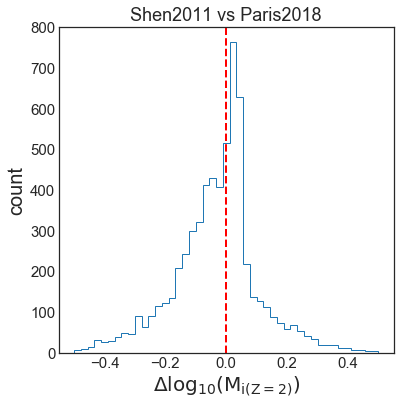

In [1016]:
plt.figure(figsize=(6,6))
plt.hist(qso_['MI_Z2'] - qso_['MI'], histtype='step', 
        bins=45, range=(-0.5,0.5),)# normed=True)
plt.axvline(0, ls='--', lw=2, c='r')
plt.xlabel(r'$\Delta \log_{10}{(\mathrm{M_{i(Z=2)}})}$')
plt.ylabel('count')
plt.title('Shen2011 vs Paris2018')
plt.savefig('MI_Z2_Shen2008_Paris2018_hist.png', bbox_inches='tight')

(array([   1.,    3.,    5.,    6.,    7.,    8.,   15.,    9.,   27.,
          37.,   38.,   70.,   89.,  170.,  177.,  260.,  292.,  423.,
         568.,  492.,  561.,  575.,  573.,  430.,  349.,  266.,  223.,
         182.,  130.,  118.,   70.,   58.,   33.,   27.,   22.,   15.,
           5.,   14.,    5.,    4.,    0.,    4.,    3.,    1.,    0.]),
 array([-0.5       , -0.45555556, -0.41111111, -0.36666667, -0.32222222,
        -0.27777778, -0.23333333, -0.18888889, -0.14444444, -0.1       ,
        -0.05555556, -0.01111111,  0.03333333,  0.07777778,  0.12222222,
         0.16666667,  0.21111111,  0.25555556,  0.3       ,  0.34444444,
         0.38888889,  0.43333333,  0.47777778,  0.52222222,  0.56666667,
         0.61111111,  0.65555556,  0.7       ,  0.74444444,  0.78888889,
         0.83333333,  0.87777778,  0.92222222,  0.96666667,  1.01111111,
         1.05555556,  1.1       ,  1.14444444,  1.18888889,  1.23333333,
         1.27777778,  1.32222222,  1.36666667,  1.41111111,

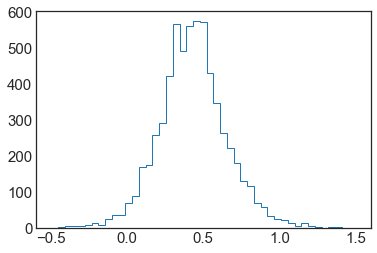

In [1012]:
plt.hist(qso_['M_i']-qso_['M_i_corr'],histtype='step', 
        bins=45, range=(-0.5,1.5),)

In [864]:
# only in one case there is a huge difference in resfhit :
# QSO 210750.44-002436.5 : 
# probablty had a very poor quality spectrum....
# this one also did not have LOGBH estimate... 

qso[abs(d)>0.1]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ptf,sigmaEXP_sdss-ps1-ptf,sigmaMAP_sdss-ps1-ptf,tauEXP_sdss-ps1-ptf,tauMAP_sdss-ps1-ptf,length_sdss-ps1-ptf-crts,sigmaEXP_sdss-ps1-ptf-crts,sigmaMAP_sdss-ps1-ptf-crts,tauEXP_sdss-ps1-ptf-crts,tauMAP_sdss-ps1-ptf-crts,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,d2d_arcsec_DR7,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGEDD_RATIO,d2d_arcsec_chelsea
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64
2762483.txt,2582.962725,0.112473289508,0.0832123591024,1860.44293198,651.484533718,4702.157172,0.12193271081,0.107258618033,154.22929152,67.3212054743,4702.157172,0.12193271081,0.107258618033,154.22929152,67.3212054743,4744.874742,0.224493755579,0.222813701275,2.9922572676,1.0,2762483,316.960205,-0.410146,72302,-23.675,-24.133,0.5852,10.553,45.723,20.332,19.663,19.139,18.935,18.753,0.462,0.00365145529067,210750.44-002436.5,316.960205078,-0.41014701128,1.35300004482,0.0,0.0,-999.0,0.0


(array([  4.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          8.00000000e+00,   8.00000000e+00,   1.10000000e+01,
          1.90000000e+01,   2.50000000e+01,   3.80000000e+01,
          7.20000000e+01,   1.27000000e+02,   3.29000000e+02,
          5.03800000e+03,   3.95000000e+02,   1.69000000e+02,
          7.40000000e+01,   3.10000000e+01,   2.70000000e+01,
          2.30000000e+01,   1.30000000e+01,   1.30000000e+01,
          1.00000000e+01,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 array([-0.04  , -0.0368, -0.0336, -0.0304, -0.0272, -0.024 , -0.0208,
        -0.0176, -0.0144, -0.0112, -0.008 , -0.0048, -0.0016,  0.0016,
         0.0048,  0.008 ,  0.0112,  0.0144,  0.0176,  0.0208,  0.024 ,
         0.0272,  0.0304,  0.0336,  0.0368,  0.04  ]),
 <a list of 1 Patch objects>)

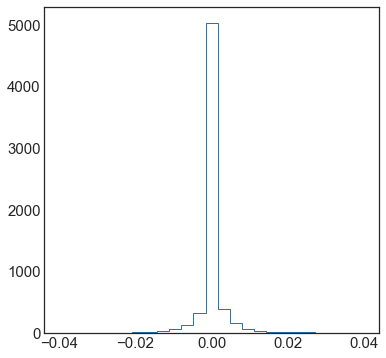

In [869]:
plt.figure(figsize=(6,6))
d = qso['redshift'] - qso['REDSHIFT']
m = abs(d) < 0.2
plt.hist(d[m], histtype='step', range=(-0.04,0.04), bins=25)

In summary, there's almost no redshift difference ...  

In [827]:
m1 = qso['Lbol']  > 0 # remove those that do not have Lbol estimates in Shen+2008 
qso[m1][abs(qso['Lbol'][m1] - qso['LOGLBOL'][m1]) > 10]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ptf,sigmaEXP_sdss-ps1-ptf,sigmaMAP_sdss-ps1-ptf,tauEXP_sdss-ps1-ptf,tauMAP_sdss-ps1-ptf,length_sdss-ps1-ptf-crts,sigmaEXP_sdss-ps1-ptf-crts,sigmaMAP_sdss-ps1-ptf-crts,tauEXP_sdss-ps1-ptf-crts,tauMAP_sdss-ps1-ptf-crts,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,d2d_arcsec_DR7,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGEDD_RATIO,d2d_arcsec_chelsea
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64
2762483.txt,2582.962725,0.112473289508,0.0832123591024,1860.44293198,651.484533718,4702.157172,0.12193271081,0.107258618033,154.22929152,67.3212054743,4702.157172,0.12193271081,0.107258618033,154.22929152,67.3212054743,4744.874742,0.224493755579,0.222813701275,2.9922572676,1.0,2762483,316.960205,-0.410146,72302,-23.675,-24.133,0.5852,10.553,45.723,20.332,19.663,19.139,18.935,18.753,0.462,0.00365145529067,210750.44-002436.5,316.960205078,-0.41014701128,1.35300004482,0.0,0.0,-999.0,0.0


In [717]:
m = qso['Lbol'] == 0 
np.sum(qso['LOGLBOL'][m] == 0 )

0

## Crossmatch to Chelsea

In [804]:
# crossmatch with Chelsea's results

cat1 = SkyCoord(ra=qso['ra']*u.degree, 
                        dec=qso['dec']*u.degree)
cat2 = SkyCoord(s82drw['ra']*u.degree,s82drw['dec']*u.degree, 
                       frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
qso['d2d_arcsec_chelsea']=sep2d.value*3600

qso_s82r = hstack([qso, s82drw[idx]])


## Aside : Rest-frame or observed frame  ? Turns out its observed. <a id='restFramevsObserved'></a>
[contents](#contents)

Figure out whether $\tau$ in Chelsea's results is observed or restframe by reproducing Fig.3 from her paper 

In [805]:
qso_s82r[:4]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ptf,sigmaEXP_sdss-ps1-ptf,sigmaMAP_sdss-ps1-ptf,tauEXP_sdss-ps1-ptf,tauMAP_sdss-ps1-ptf,length_sdss-ps1-ptf-crts,sigmaEXP_sdss-ps1-ptf-crts,sigmaMAP_sdss-ps1-ptf-crts,tauEXP_sdss-ps1-ptf-crts,tauMAP_sdss-ps1-ptf-crts,dbID,ra_1,dec_1,SDR5ID_1,M_i_1,M_i_corr,redshift_1,mass_BH_1,Lbol,u,g,r,i,z,Au,d2d_arcsec_DR7,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGEDD_RATIO,d2d_arcsec_chelsea,SDR5ID_2,ra_2,dec_2,redshift_2,M_i_2,mass_BH_2,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,SFinf
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64
233.txt,3321.033842,0.112765414555,0.0898995121063,981.875197365,270.133423745,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.115511511771,0.113080341967,17.7186414587,12.1535796268,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,0.00718657465285,000119.50+001038.0,0.331288993359,0.17722800374,1.6209000349,45.9522119138,8.92171816669,-1.069876798,0.0,58,0.331289,0.17723,1.6199,-24.735,0.0,1.19407,2.44022,-0.848145,2.24434,4.1202,-1.02269,-0.781607,0,134.36,107.71,132.865,20.3141,57,0.123258979507
1018.txt,3336.933302,0.219967338358,0.166799870973,1005.98831672,331.440202397,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.208861039395,0.205851702862,1.12644722505,1.0,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,0.0108218821638,000527.52-000556.2,1.36469900608,-0.0989559963346,0.612399995327,45.3939103924,9.02221107204,-1.72867122474,0.0,190,1.364696,-0.098956,0.6125,-23.121,0.0,1.12426,2.87294,-0.627733,2.72995,4.49924,-0.719803,-0.591494,0,152.593,82.2158,152.094,19.4742,62,0.336969480031
1327.txt,3336.933324,0.10176772487,0.0824972045393,567.610084936,215.218303228,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5865.0169872,0.137629240634,0.13302700692,22.3107288091,17.5193899944,1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139,0.0210127501153,000107.52+004113.1,0.281367003918,0.68698900938,1.39900004864,46.0356964494,8.77970169839,-0.844375794117,0.0,49,0.28137,0.686984,1.3988,-24.917,8.817,0.870333,2.5301,-0.832748,2.3953,4.21627,-0.94041,-0.795638,0,175.03,103.201,173.65,19.72,63,0.14163010195
1540.txt,3321.033885,0.097085050401,0.0829833542739,2833.63335653,2078.35617054,5141.047905,0.409454462022,0.403394414457,1.00355321529,1.0,5141.047905,0.409454462022,0.403394414457,1.00355321529,1.0,5859.0268622,0.349226747464,0.346859742043,1.00008007328,1.0,1540,2.607954,0.913245,370,-27.263,-27.856,2.8473,0.0,0.0,21.346,19.15,19.093,18.944,18.758,0.122,0.00695700118753,001025.90+005447.6,2.60795593262,0.913245022297,2.85730004311,46.8489459039,9.16110841789,-0.412533059113,0.0,370,2.607954,0.913245,2.8473,-27.263,0.0,1.11517,5.0,-1.325,3.43892,4.71963,-1.41087,-1.21987,1,165.111,106.772,165.11,18.961,52,0.783165536232


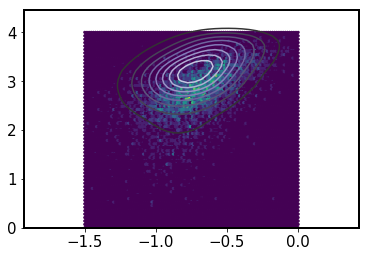

In [488]:
import seaborn as sns 
fig,ax  = plt.subplots(1,1)

m2 = qso_s82drw['Plike'] - qso_s82drw['Pnoise'] > 2 
m3 = qso_s82drw['Plike'] - qso_s82drw['Pinf'] > 0.05 
m4 = qso_s82drw['edge'] == 0 
m = m2&m3&m4

extent = [-1.5,0,0,4]
ax.hexbin(np.log10(qso_s82drw['SFinf'][m]) , 
           qso_s82drw['log10tau'][m],extent=extent)  # assuming tau is obs 


x = np.log10(qso_s82drw['SFinf'])
t = np.power(10,qso_s82drw['log10tau'] )
tcorr = t * (1+qso_s82drw['redshift_1'])
y = np.log10(tcorr)  # assuming tau is rest frame 

mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])

m = mx & my & m2 & m3 & m4

sns.kdeplot(x[m] , y[m] , 
            cmap="Purples_d", gridsize=50, 
            shade=False, bw=.15 , legend=False, ax=ax) 

Compare to Fig.3 of MacLeod+2010 which was done in restframe ... ( trest = tobs / (1+z) )

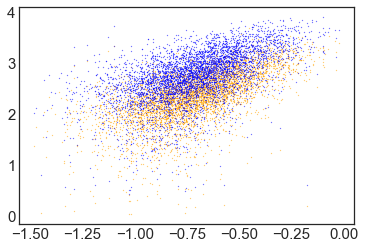

In [589]:
import seaborn as sns 
fig,ax  = plt.subplots(1,1)

m2 = qso_s82drw['Plike'] - qso_s82drw['Pnoise'] > 2 
m3 = qso_s82drw['Plike'] - qso_s82drw['Pinf'] > 0.05 
m4 = qso_s82drw['edge'] == 0 


# # assuming tau is obs : conv to restframe by dividing by redshift
tobs = np.power(10,qso_s82drw['log10tau'])
trest = tobs / (1+qso_s82drw['redshift_1'])
x = np.log10(qso_s82drw['SFinf'])
y = np.log10(trest) 


extent = [-1.5,0,0,4]
mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])
m = mx & my & m2 & m3 & m4

ax.scatter(x[m], y[m], s=0.05, c='orange')

# assuming tau is rest frame  : keep unchanged  
x = np.log10(qso_s82drw['SFinf'])
y = qso_s82drw['log10tau'] 

mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])
m = mx & my & m2 & m3 & m4

ax.scatter(x[m] , y[m] ,s=0.05, c='blue')

Comparing to Fig.3  in MacLeod+2010 which plots the rest-frame it looks like the **timescales reported on the website** by Chelsea are the **observed** ones. This is because if we look at Fig.3,  the orange dots (assuming she stored obs frame, converting to restframe ) are more aligned with the distribution on that figure than the blue dots (assuming she stored rest frame, in which case there would have been no need for a conversion ). 

## Compare  Chelsea $\tau$ to Celerite $\tau_{MAP}$ and $\tau_{EXP}$ :  <a id='chelsea_vs_celerite'></a>
[contents](#contents)

4828


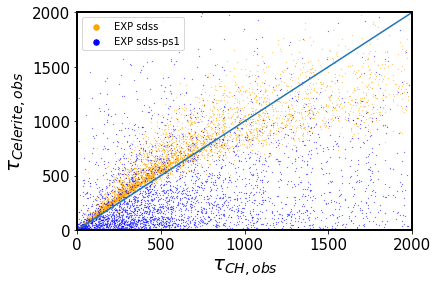

In [99]:
# read the combined file  with Celerite real results 
# and Chelsea r-band ....
s82 = Table.read('190228_Celerite_real_Jeff1_radec_s82drw_r.txt', format='ascii')

m2 = s82['Plike'] - s82['Pnoise'] > 2 
m3 = s82['Plike'] - s82['Pinf'] > 0.05 
m4 = s82['edge'] == 0 

m = m2&m3&m4
print(np.sum(m))


# plot all in obs frame 
y1 = s82['tauEXP_sdss'][m] 
x = np.power(10, s82['log10tau'][m]) 
# chelsea convert to obs frame 
plt.scatter(x,y1, c='orange',label='EXP sdss', s=0.05)

y2 = s82['tauEXP_sdss-ps1'][m]
plt.scatter(x,y2 ,c='blue', label='EXP sdss-ps1', s=0.05)

#plt.scatter(x,(y1+y2)/2 ,c='red', label='mean', s=0.05)
plt.xlim(0,2000)
plt.ylim(0,2000)
x1 = np.linspace(0,2000)
plt.plot(x1,x1, label='')
plt.xlabel(r'$\tau_{CH,obs}$')
plt.ylabel(r'$\tau_{Celerite,obs}$')
lgnd =  plt.legend()
for i in range(len(lgnd.legendHandles)): # set the size of legend marger manually 
    lgnd.legendHandles[i]._sizes = [30]


Looks like my EXP is above, while MAP below, Chelsea's MAP fits... It;'s interesting that the mean of EXP and MAP from Celerite much more follows Chelsea's results ! '

4828


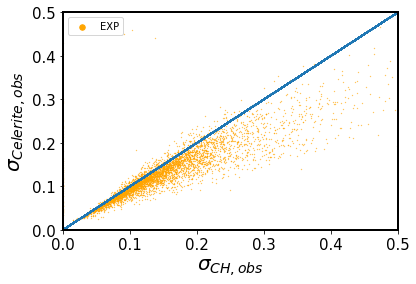

In [100]:
m2 = s82['Plike'] - s82['Pnoise'] > 2 
m3 = s82['Plike'] - s82['Pinf'] > 0.05 
m4 = s82['edge'] == 0 
m = m2&m3&m4
print(np.sum(m))

# plot all in obs frame 
y1 = s82['sigmaEXP_sdss'][m] 
x =  s82['SFinf'][m] / np.sqrt(2)

# chelsea convert to obs frame 
plt.scatter(x,y1, c='orange',label='EXP', s=0.08)

y2 =s82['sigmaMAP_sdss'][m]
#plt.scatter(x,y2 ,c='blue', label='MAP', s=0.05)

#plt.scatter(x,(y1+y2)/2 ,c='red', label='mean', s=0.05)
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.plot(x,x, label='')
plt.xlabel(r'$\sigma_{CH,obs}$')
plt.ylabel(r'$\sigma_{Celerite,obs}$')
lgnd =  plt.legend()
for i in range(len(lgnd.legendHandles)): # set the size of legend marger manually 
    lgnd.legendHandles[i]._sizes = [30]



Meanwhile, Sigma agrees completely! ( And doesn't change whether we use with Celerite just SDSS or SDSS+PS1 ) .... 

So my comparison of sigma, tau still makes sense... 

In [512]:
#qso_s82drw

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Median log10(sigma_sdss-ps1/sigma_sdss)= 0.046363664175716024
Mean log10(sigma_sdss-ps1/sigma_sdss)= 0.08188996032277528
Median log10(tau_sdss-ps1/tau_sdss)= -0.3663760973162964
Mean log10(tau_sdss-ps1/tau_sdss)= -0.46161652012286936


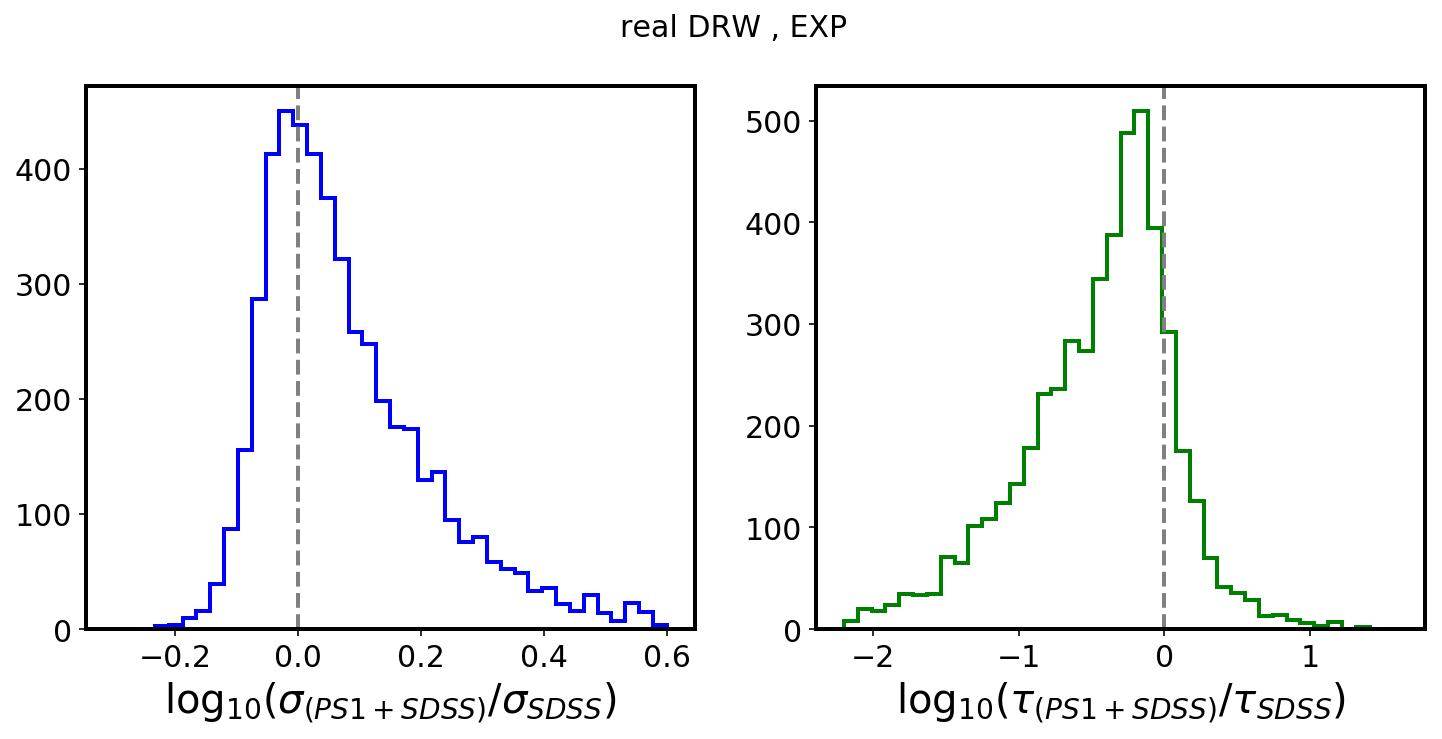

In [34]:
%config InlineBackend.figure_format='retina'
# plot changes in tau only for QSO for which Chelsea was more certain...

# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

fit='EXP'

fig,ax = plt.subplots(1,2, figsize=(12,5))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []

i = 0

labels = {'sigma': r'$\log_{10}{(\sigma_{(PS1+SDSS)} / \sigma_{SDSS})}$',
         'tau':r'$\log_{10}{(\tau_{(PS1+SDSS)} / \tau_{SDSS})}$'}

m2 = s82['Plike'] - s82['Pnoise'] > 2 
m3 = s82['Plike'] - s82['Pinf'] > 0.05 
m4 = s82['edge'] == 0 
m = m2&m3&m4

ranges = {'sigma':[-0.3,0.6], 'tau':[-2.2,1.6]}

for q in ['sigma','tau']:
    m = s82['tau'+fit+'_sdss-ps1'] > 5 
    x = (s82[q+fit+'_sdss-ps1'][m] )/ s82[q+fit+'_sdss'][m]
    ax[i].hist(np.log10(x), histtype='step', 
               bins=40, range=ranges[q], color = colors[i],lw=2) 
    
    print('Median log10('+q+'_sdss-ps1/'+q+'_sdss'+')=', np.median(np.log10(x)))
    print('Mean log10('+q+'_sdss-ps1/'+q+'_sdss'+')=', np.mean(np.log10(x)))
    
    ax[i].set_xlabel(labels[q])
    ax[i].axvline(0, lw=2, ls='--', c='grey')
    i += 1 

fig.suptitle(sim + ' DRW , '+ fit , fontsize = 15)
plt.savefig('Celerite_real_DRW_EXP_compare_tau.png', bbox_inches='tight')

Plot  $\tau_{Celerite} / \tau_{Chelsea}$ vs. $\tau_{Chelsea}$, for SDSS,  and SDSS-PS1 segments : 

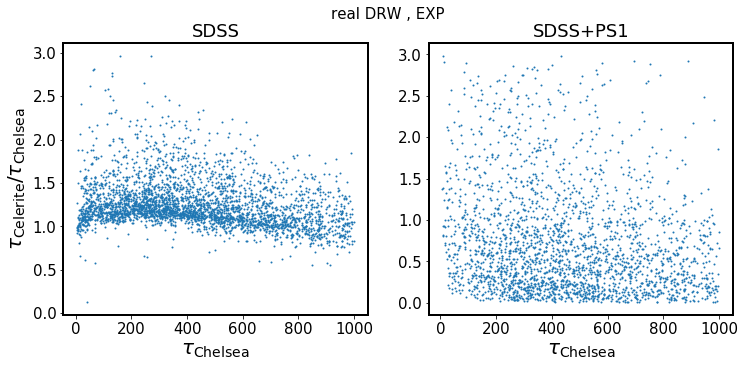

In [102]:
fig,ax = plt.subplots(1,2, figsize=(12,5))

m1 = s82['Plike'] - s82['Pnoise'] > 2 
m2 = s82['Plike'] - s82['Pinf'] > 0.05 
m3 = s82['edge'] == 0 

fit = 'EXP'

i = 0 
for seg in ['sdss', 'sdss-ps1'] : 
    m4 = s82['tau'+fit+'_'+seg] > 5 
    
    
    
    y = (s82['tau'+fit+'_'+seg] )/ np.power(10,s82['log10tau'])
    x = np.power(10,s82['log10tau'])
    
    m5 = x < 1000.
    m6 = y < 3
    
    m = m1&m2&m3&m4&m5&m6
    
    ax[i].scatter(x[m],y[m], s=1.)
    ax[i].set_xlabel(r'$\tau_{\mathrm{Chelsea}}$')
    i += 1 
    
ax[0].set_ylabel(r'$\tau_{\mathrm{Celerite}}/\tau_{\mathrm{Chelsea}}$')
ax[0].set_title('SDSS')
ax[1].set_title('SDSS+PS1')
fig.suptitle(sim + ' DRW , '+ fit , fontsize = 15)

plt.savefig('Celerite_Chelsea_real_DRW_compare_tau_EXP.png', bbox_inches='tight')

In [77]:
s82

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra_1,dec_1,SDR5ID_1,M_i_1,M_i_corr,redshift_1,mass_BH_1,Lbol,u,g,r,i,z,Au,SDR5ID_2,ra_2,dec_2,redshift_2,M_i_2,mass_BH_2,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,SFinf
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64
233.txt,3321.0338420000044,0.10075751425165866,0.08457207262730722,656.8411333494078,193.68268108139895,5505.090184000001,0.08836165515962953,0.08481144613166788,23.17606014197748,15.432798620779016,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,58,0.331289,0.17723,1.6199,-24.735,0.0,1.19407,2.44022,-0.848145,2.24434,4.1202,-1.02269,-0.781607,0,134.36,107.71,132.865,20.3141,57,0.12325897950662115
1018.txt,3336.9333019999976,0.19658989986620978,0.15925866404367295,717.7566916392584,289.67763034974274,5511.071033,0.21944178126621033,0.2084173212910267,2.326795898528782,34.18145321920661,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,190,1.364696,-0.098956,0.6125,-23.121,0.0,1.12426,2.87294,-0.627733,2.72995,4.49924,-0.719803,-0.591494,0,152.593,82.2158,152.094,19.4742,62,0.33696948003053717
1327.txt,3336.933323999998,0.09386092410592684,0.08008109991945163,401.9078025109211,193.64023845008344,5511.074029999996,0.1406114535927338,0.13532387127358367,14.78234481042374,11.691528536439487,1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139,49,0.28137,0.686984,1.3988,-24.917,8.817,0.870333,2.5301,-0.832748,2.3953,4.21627,-0.94041,-0.795638,0,175.03,103.201,173.65,19.72,63,0.14163010195042328
1540.txt,3321.033884999997,0.09302541943027218,0.07824425043422796,2584.5762528494092,1723.6989668554659,5141.047904999999,0.40943243061572965,0.40339439488823703,1.0033014997856988,1.0,1540,2.607954,0.913245,370,-27.263,-27.856,2.8473,0.0,0.0,21.346,19.15,19.093,18.944,18.758,0.122,370,2.607954,0.913245,2.8473,-27.263,0.0,1.11517,5.0,-1.325,3.43892,4.71963,-1.41087,-1.21987,1,165.111,106.772,165.11,18.961,52,0.7831655362322905
1580.txt,3336.9332989999966,0.10291795105010643,0.08951536556977513,280.9587329328324,138.42844568239968,5147.032183999996,0.09446325344981985,0.08784320539612213,113.62855433976094,73.05229440845268,1580,1.669492,0.643952,229,-24.427,-24.898,1.3383,8.666,45.862,20.732,20.572,20.13,20.079,20.231,0.207,229,1.669492,0.643952,1.3383,-24.427,8.666,0.987443,2.3469,-0.714265,2.19097,3.9847,-0.839718,-0.670921,0,149.463,99.129,147.676,20.0716,61,0.15067408672366103
2113.txt,3321.033829,0.19962266210869253,0.16204424298201778,1444.6503354926886,647.9661811869423,5141.041652,0.27516118374294146,0.26946050456488385,1.1038477767790493,1.0,2113,4.850273,-0.276395,699,-25.251,-25.695,1.769,0.0,0.0,19.956,20.066,20.152,19.886,19.618,0.147,699,4.850273,-0.276395,1.769,-25.251,0.0,1.07542,2.90037,-0.789369,2.75814,4.4926,-0.908632,-0.723503,0,115.51,74.7377,114.929,20.2314,51,0.23970084651702747
2306.txt,3321.0339909999966,0.12341481404292387,0.10093059230311606,715.5495291012808,215.4104633340712,5141.043961999996,0.12334391137417539,0.1049073569735343,725.9900796404103,259.6640997865137,2306,4.026021,0.478127,578,-24.999,-25.581,1.8725,0.0,0.0,20.772,20.708,20.599,20.262,20.201,0.128,578,4.026021,0.478127,1.8725,-24.999,0.0,1.05418,2.78995,-0.810464,2.64728,4.5279,-0.953375,-0.752173,0,113.847,84.8468,113.566,20.5042,53,0.20107800502635853
2401.txt,3321.033902999996,0.057958507039900686,0.04705511059402068,974.948384375

May be useful to compare the distributions to Fig.6,14 in MacLeod+2011 (the observed distribution) ,  or to Fig.3 in MacLeod+2010 (the rest-frame distribution) . 


In what follows I **reproduce MacLeod+2010 results with her data**,  to make sure that any changes that I see are because of my results, and not because of any problems with the code ..  

## MacLeod+2010, Fig. 3 : plotting ($\tau_{RF}$, $SF_{\infty}$)  <a id='ChelseaFig3'></a>
[contents](#contents)

Since Chelsea stored in her s82drw the observed quantity  'log10tau' , we convert to rest-frame with 

$\tau_{rest} = \tau_{obs} / (1+z) $ 

I do the same for Celerite fits, since they were also done on observed light curves. 

$SF_{\infty}$ does not require any correction.

In [2]:
import seaborn as sns
s82 = Table.read('190228_Celerite_real_Jeff1_radec_s82drw_r.txt', format='ascii')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10


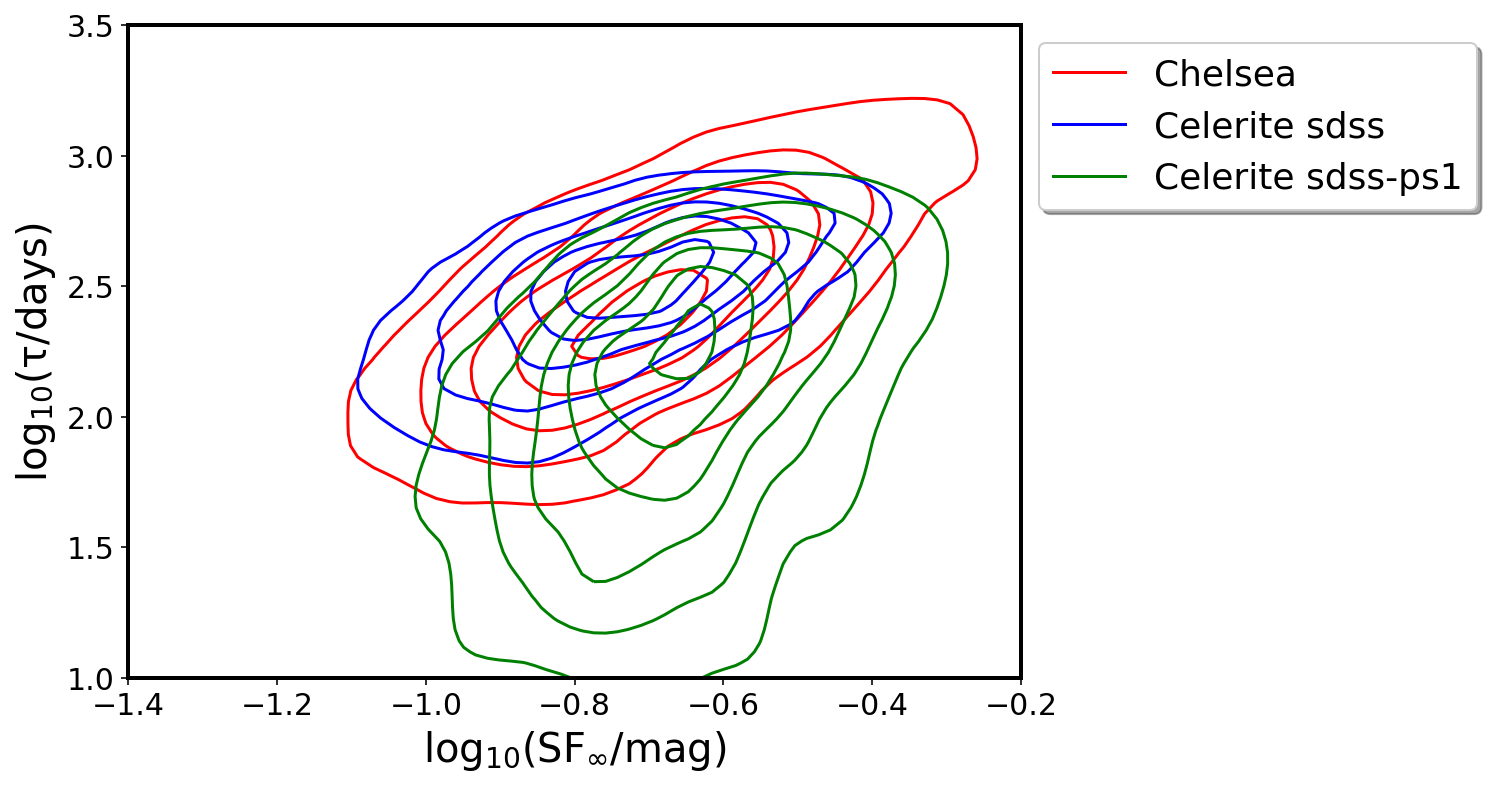

In [25]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# do the same selection as Chelsea
m1 = (s82['log10sigmahat'] > -10)*(s82['log10tau'] > -10)
m2 = s82['Plike'] - s82['Pnoise'] > 2 
m3 = s82['Plike'] - s82['Pinf'] > 0.05 
m4 = s82['edge'] == 0 

# choose the same extent as Fig.3 MacLeod+2010 
extent = [-1.5,0, 0,5]

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax_legend_handles = []


# If Chelsea's were already RF ... 
# tRF = np.power(10,s82['log10tau'])
# x = np.log10(s82['SFinf'])
# y = np.log10(tRF)
# mx = (extent[0] < x) * (x < extent[1])
# my = (extent[2] < y) * (y < extent[3])

# m = mx&my&m1&m2&m3&m4 
# sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
#             linestyles='-', linewidth=2, cmap=None, colors='purple',)
# line = mlines.Line2D([], [],  color='purple', label='ChelseaRF')
# ax_legend_handles.append(line)

# Plot Chelsea's results ( s82drw...  - only r-band )
# # assuming tau is obs : conv to restframe by dividing by redshift
tobs = np.power(10,s82['log10tau'])
trest = tobs / (1+s82['redshift_1'])

x = np.log10(s82['SFinf'])
y = np.log10(trest) 

mx = (extent[0] < x) * (x < extent[1])
my = (extent[2] < y) * (y < extent[3])

m = mx&my&m1&m2&m3&m4 


sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
            linestyles='-', linewidth=2, cmap=None, colors='r',)
line = mlines.Line2D([], [],  color='r', label='Chelsea')
ax_legend_handles.append(line)

 
    
# Plot Celerite results ... 
for seg,color  in zip(['sdss','sdss-ps1'], ['blue','green']):
    sfinf = np.sqrt(2) * s82['sigmaEXP_'+seg]
    tauOBS = s82['tauEXP_'+seg]
    tauRF = tauOBS / (1+s82['redshift_1'])
    x = np.log10(sfinf)
    y = np.log10(tauRF)
    m5 = tau > 2
    m = mx&my&m1&m2&m3&m4&m5
    #ax.scatter(x[m], y[m], s=0.05)
    sns.kdeplot(x[m],y[m], n_levels=6, ax=ax,
                linestyles='-', linewidth=2, cmap=None, colors=color, )
    line = mlines.Line2D([], [],  color=color, label='Celerite '+seg)
    ax_legend_handles.append(line)


ax.legend(loc='upper left', handles = ax_legend_handles, bbox_to_anchor=(1,1),
            ncol=1, fancybox=True, shadow=True, fontsize=18 ) 


ax.set_xlabel(r'$\log_{10}{(\mathrm{SF_{\infty}/mag})}$')
ax.set_ylabel(r'$\log_{10}{(\mathrm{\tau/ days})}$')
ax.set_xlim(-1.4, -0.2)
ax.set_ylim(1,3.5)

plt.savefig('MacLeod2010_Fig3_restframe_.png', bbox_inches='tight', dpi=100)

## MacLeod+2010 Fig.12 : properties of QSO sample <a id='ChelseaFig12'></a>
[contents](#contents)

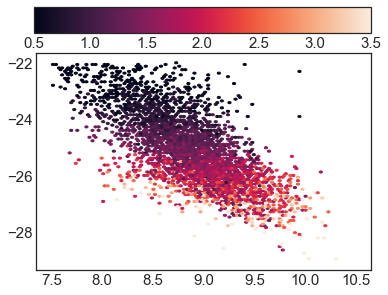

In [735]:
fig,ax = plt.subplots()
image = ax.hexbin(qso_s82drw['mass_BH_1'], qso_s82drw['M_i_1'], 
                     qso_s82drw['redshift_1'] ,extent = [7.5,10.5, -22,-29],
                  vmin = 0.5, vmax =3.5,)
left, bottom, width, height = 0.12, 0.95, 0.78, 0.09
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal')

In [979]:
qso_

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ptf,sigmaEXP_sdss-ps1-ptf,sigmaMAP_sdss-ps1-ptf,tauEXP_sdss-ps1-ptf,tauMAP_sdss-ps1-ptf,length_sdss-ps1-ptf-crts,sigmaEXP_sdss-ps1-ptf-crts,sigmaMAP_sdss-ps1-ptf-crts,tauEXP_sdss-ps1-ptf-crts,tauMAP_sdss-ps1-ptf-crts,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,d2d_arcsec_DR7,SDSS_NAME_1,RA_1,DEC_1,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,d2d_arcsec_DR14,SDSS_NAME_2,RA_2,DEC_2,THING_ID,Z,MI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-,deg,deg,-,-,-
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,int32,float64,float64
233.txt,3321.033842,0.112765414555,0.0898995121063,981.875197365,270.133423745,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.115511511771,0.113080341967,17.7186414587,12.1535796268,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,0.00718657465285,000119.50+001038.0,0.331288993359,0.17722800374,1.6209000349,45.9522119138,8.92171816669,0.204242161504,-1.069876798,-25.0089606857,1.99839188402e-13,000119.50+001038.0,0.331288993359,0.17722800374,-1,1.6209,-25.04644
1018.txt,3336.933302,0.219967338358,0.166799870973,1005.98831672,331.440202397,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.208861039395,0.205851702862,1.12644722505,1.0,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,0.0108218821638,000527.52-000556.2,1.36469900608,-0.0989559963346,0.612399995327,45.3939103924,9.02221107204,0.267494722292,-1.72867122474,-24.0391556866,0.0,000527.52-000556.2,1.36469900608,-0.0989559963346,-1,0.6124,-23.589289
1327.txt,3336.933324,0.10176772487,0.0824972045393,567.610084936,215.218303228,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5865.0169872,0.137629240634,0.13302700692,22.3107288091,17.5193899944,1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139,0.0210127501153,000107.52+004113.1,0.281367003918,0.68698900938,1.39900004864,46.0356964494,8.77970169839,0.100770668469,-0.844375794117,-25.2308241422,0.0,000107.52+004113.1,0.281367003918,0.68698900938,-1,1.399,-25.267258
1540.txt,3321.033885,0.097085050401,0.0829833542739,2833.63335653,2078.35617054,5141.047905,0.409454462022,0.403394414457,1.00355321529,1.0,5141.047905,0.409454462022,0.403394414457,1.00355321529,1.0,5859.0268622,0.349226747464,0.346859742043,1.00008007328,1.0,1540,2.607954,0.913245,370,-27.263,-27.856,2.8473,0.0,0.0,21.346,19.15,19.093,18.944,18.758,0.122,0.00695700118753,001025.90+005447.6,2.60795593262,0.913245022297,2.85730004311,46.8489459039,9.16110841789,0.0607332547083,-0.412533059113,-27.8063372951,0.0452186922424,001025.91+005447.6,2.607958662,0.913232761597,116665877,2.86,-27.780611
1580.txt,3336.933299,0.110542000348,0.0920232262927,406.837957723,155.445669783,5147.032184,0.0970246015486,0.089378878649,132.925722294,81.0653330761,5147.032184,0.0970246015486,0.089378878649,132.925722294,81.0653330761,5483.982094,0.126533555511,0.117356665191,139.474587967,84.2646981058,1580,1.669492,0.643952,229,-24.427,-24.898,1.3383,8.666,45.862,20.732,20.572,20.13,20.079,20.231,0.207,0.00496204394004,000640.67+003838.2,1.66949105263,0.643950998783,1.3370000124,45.84

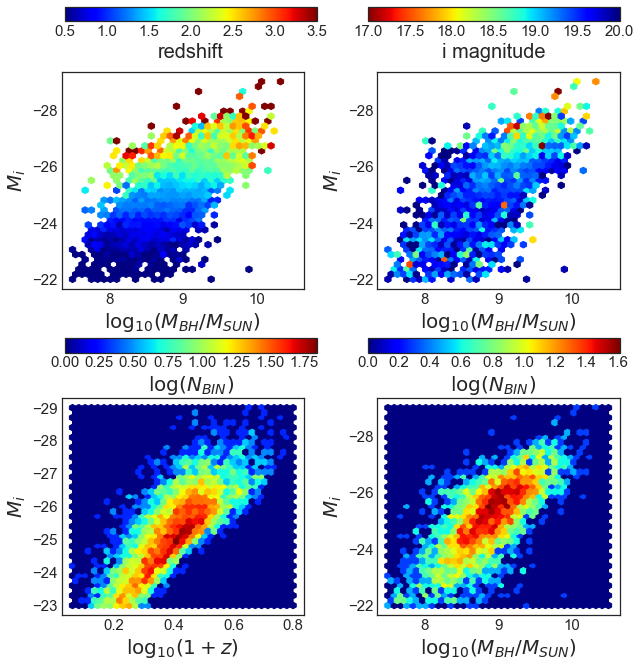

In [986]:
# plotted quantities : 
# absolute i-band magnitude 
MI = qso_['M_i']

## i-band magnitude 
imag = qso_['i']

# redshift
z =  qso_['redshift']

# black hole mass from Shen+2008 (Chelsea's catalog)
MBH = qso_['mass_BH']


fig,axs = plt.subplots(2,2, figsize=(10,10))
ax = np.ravel(axs)

# upper left 
image = ax[0].hexbin(MBH, MI, z ,
            extent = [7.5,10.5, -22,-29], vmin = 0.5, vmax =3.5, cmap='jet',
                    gridsize=35)
ax[0].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[0].set_ylabel(r'$M_{i}$')
ax[0].invert_yaxis()

left, bottom, width, height = 0.13, 0.95, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label='redshift')

fig.subplots_adjust(hspace=0.4)


# upper right  
image = ax[1].hexbin(MBH, MI,imag ,
            extent = [7.5,10.5, -22,-29],  vmin=17, vmax = 20, cmap='jet_r',
                    gridsize=35)
ax[1].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[1].set_ylabel(r'$M_{i}$')
ax[1].invert_yaxis()

left, bottom, width, height = 0.55, 0.95, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label='i magnitude')



# lower left 
image = ax[2].hexbin(np.log10(1+z),MI,
            extent = [0.06,0.8, -23,-29],  cmap='jet',
                    gridsize=35, bins='log',)
#                     vmin = 0.6, vmax =3.5,) 
ax[2].set_xlabel(r'$\log_{10}{(1+z)}$')
ax[2].set_ylabel(r'$M_{i}$')
ax[2].invert_yaxis() 
left, bottom, width, height = 0.13, 0.49, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log{(N_{BIN})}$')


# lower right 
image = ax[3].hexbin(MBH, MI,
            extent = [7.5,10.5, -22,-29],  cmap='jet',
                    gridsize=35, bins='log',
                    ) # vmin = 0.6, vmax =3., 
ax[3].invert_yaxis() 
ax[3].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[3].set_ylabel(r'$M_{i}$')
left, bottom, width, height = 0.55, 0.49, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log{(N_{BIN})}$')

fig.subplots_adjust(hspace=0.5,wspace=0.3)
plt.savefig('macleod2010_Fig12.png', bbox_inches='tight')

Looks the same as Chelsea's Fig  - since the quasars used are teh same... 

## MacLeod+2010, Fig.13 (wavelength dependence of $\tau$, $SF_{\infty}$ ) : her  ugriz results  vs Celerite single-band r EXP... <a id='readChelseaAll'></a>
[contents](#contents)

Read in all her results for individual bands ... 

In [8]:
# read in Shen+2011 to add to her resutls ....
cat = Table.read("dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
shen2011 = cat[abs(cat['DEC']) < 1.5]['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO','MI_Z2' ]

# add DBQSO M_i_corr , since it's slightly different than MI_Z2 ...
File = '../../CRTS_PROJECT/catalogs_SDSS/DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
dbqso = Table.read(File, format='ascii', names = colnames)

s82 = {}
# wavelength of observed bandpass 
lambdaobs = {'u':3520, 'g':4800, 'r':6250, 'i':7690, 'z' : 9110 }

for f in 'ugriz':
    s82[f] = Table.read('s82drw_'+f+'.dat', format='ascii',
                   names = ['SDR5ID', 'ra','dec', 'redshift', 'M_i', 'mass_BH',
                            'chi2_pdf', 'log10tau', 'log10sigmahat',
                            'log10tau_lim_lo','log10tau_lim_hi',
                            'log10sigmahat_lim_lo','log10sigmahat_lim_hi',
                            'edge', 'Plike', 'Pnoise', 'Pinf', 'mu', 'Npts'])
    
    # her selection (chapter 3, macleod2010) was to use only those 
    # where 
    print('\nFor ', f , ' band starting with ', len(s82[f]))
    m1 = s82[f]['Npts'] > 10 
    print('Npts>10 ', np.sum(m1))
    m2 = s82[f]['Plike'] - s82[f]['Pnoise'] > 2 
    print('Plike - Pnoise  > 2 ' , np.sum(m2))
    m3 = s82[f]['Plike'] - s82[f]['Pinf'] > 0.05 
    print('Plike - Pinf > 0.05  ', np.sum(m3))
    m4 = s82[f]['edge'] == 0 
    print('edge == 0  ', np.sum(m4))
    m = m1&m2&m3&m4
    print('Combined kept : ', np.sum(m))
    s82[f] = s82[f][m]
    
    # make a column saying what the middle of the observed filter 
    # corresponds to in QSO rest frame ... ( sec. 5.1)       tface
    s82[f]['lambdaRF'] = lambdaobs[f] /  (1.+ s82[f]['redshift'])
    
    # convert tau  to restframe  (SF doesn't need that since amplitude 
    # is not time-dilated )
     
    s82[f]['SFinf']  = np.power(10,s82[f]['log10sigmahat']) * \
                  np.sqrt(np.power(10,s82[f]['log10tau']) / 365.)  
        # # b/c her sigma hat in mag / sqrt(year)  rather than mag / sqrt(days), 
        # and tau is in days 
    s82[f]['tauRF'] = np.power(10,s82[f]['log10tau'])  / (1.+ s82[f]['redshift'])
    
    # no need to move SFinf to Rest Frame, since it is not affected in the 
    # slightest by using a different frame ... 
    #s82[f]['SFinfRF'] = s82[f]['SFinf'] / (1.+ s82[f]['redshift'])

    
    # make a column with SFinf,  tau  converted to  4000 angstroms using 
    # Chelsea's coefficients 
    s82[f]['SFinf4000'] = s82[f]['SFinf'] * np.power(4000 / s82[f]['lambdaRF'], -0.479)
    s82[f]['tau4000'] = s82[f]['tauRF'] * np.power(4000 / s82[f]['lambdaRF'] , 0.17 )

    
    # add info about Shen+2011   Lbol,  MBH,  etc.  
    cat1 = SkyCoord(ra=s82[f]['ra']*u.degree, 
                dec=s82[f]['dec']*u.degree)
    cat2 = SkyCoord(shen2011['RA']*u.degree,shen2011['DEC']*u.degree, 
                       frame='icrs') 
    # grab shen2011 values for BH mass, Lbol, Redshift.... 
    idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
    s82[f]['d2d_asec_Shen11'] = sep2d.value*3600

    s82[f]= hstack([s82[f], shen2011[idx]])

    # add DBQSO 
    cat1 = SkyCoord(ra=s82[f]['ra']*u.degree, 
                  dec=s82[f]['dec']*u.degree)
    cat2 = SkyCoord(dbqso['ra']*u.degree,dbqso['dec']*u.degree, 
                       frame='icrs') 
    # add DBQSO 'M_i_corr'
    idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
    s82[f]['d2d_asec_DBQSO'] = sep2d.value*3600
    s82[f]= hstack([s82[f], dbqso[idx][['M_i_corr']]])
   
# save the dictionary ...
np.save('s82drw_shen2011_dbqso_dic', s82)


For  u  band starting with  9258
Npts>10  9135
Plike - Pnoise  > 2  8402
Plike - Pinf > 0.05   7827
edge == 0   8148
Combined kept :  7014

For  g  band starting with  9258
Npts>10  9137
Plike - Pnoise  > 2  9130
Plike - Pinf > 0.05   7641
edge == 0   8180
Combined kept :  7408

For  r  band starting with  9258
Npts>10  9139
Plike - Pnoise  > 2  9128
Plike - Pinf > 0.05   7103
edge == 0   7823
Combined kept :  6871

For  i  band starting with  9258
Npts>10  9138
Plike - Pnoise  > 2  8964
Plike - Pinf > 0.05   7213
edge == 0   7868
Combined kept :  6814

For  z  band starting with  9258
Npts>10  9137
Plike - Pnoise  > 2  7505
Plike - Pinf > 0.05   6719
edge == 0   7365
Combined kept :  5111


Load the multi-band dictionary of Chelsea's 2011 results 

In [3]:
s82 = np.load('s82drw_shen2011_dbqso_dic.npy').item()

Plot rest frame quantities : 

Weird... why can't I reproduce the results ? 

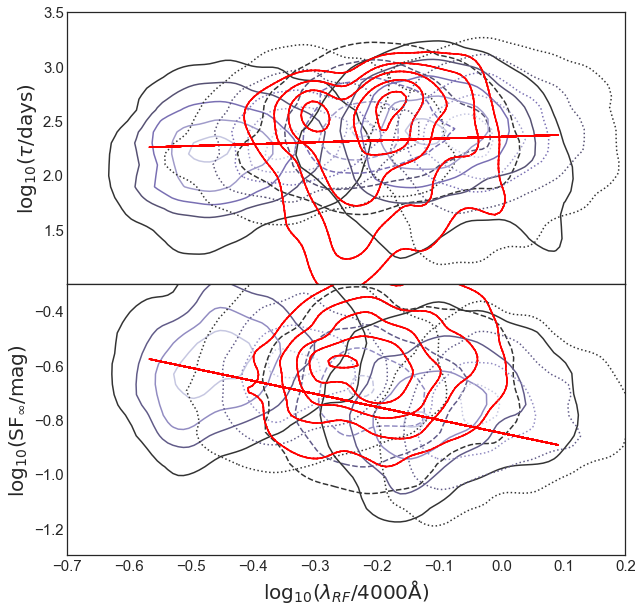

In [712]:
def convert_to_stdev(z):
    shape = z.shape
    z = z.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(z)[::-1]
    i_unsort = np.argsort(i_sort)

    z_cumsum = z[i_sort].cumsum()
    z_cumsum /= z_cumsum[-1]

    return z_cumsum[i_unsort].reshape(shape)


ls = {'u':'-',  'g':':', 'r': '--', 'i': '-', 'z': ':' }
lw = {'u':3,    'g': 1,  'r':  2  , 'i': 1  , 'z': 3}
xlims = [-0.7,0.2]
ylims = {0: [1,3.5] , 1:[-1.3,-0.3]}
n_levels = 5 

fig,ax = plt.subplots(2,1,figsize=(10,10))

use_kde = True #  True 
seg = 'sdss-ps1' # -ptf

for f in  'ugriz' : 
    x  = np.log10(s82[f]['lambdaRF'] / 4000 )
    y1 = np.log10(s82[f]['tauRF'])
    y2 = np.log10(s82[f]['SFinf']) # np.log10(s82[f]['SFinfRF'])
    
    if use_kde : 
        sns.set_style("white")
        # seaborn contour plot line style ...
        # https://stackoverflow.com/questions/49671053/seaborn-changing-line-styling-in-kdeplot
        
        # Chelsea 
        sns.kdeplot(x,y1, n_levels=n_levels, cmap="Purples_d", ax=ax[0],
                   linestyles=ls[f], linewidth=lw[f])
        sns.kdeplot(x,y2, n_levels=n_levels, cmap="Purples_d", ax=ax[1],
                   linestyles=ls[f], linewidth=lw[f])
        
        # Celerite 
        tau = qso_s82drw['tauEXP_'+seg]
        m = tau > 3 
        tauRF = tau / (1. + qso_s82drw['redshift_1'])
        SFinf = np.sqrt(2) * qso_s82drw['sigmaEXP_'+seg] 
        x = np.log10(qso_s82drw['lambdaRF'][m] / 4000)
        y1 = np.log10(tauRF[m])
        y2 = np.log10(SFinf[m])
        sns.kdeplot(x,y1, n_levels=n_levels, ax=ax[0],
                   linestyles=ls[f], linewidth=lw[f], cmap=None, colors='r')
        sns.kdeplot(x,y2, n_levels=n_levels, ax=ax[1],
                   linestyles=ls[f], linewidth=lw[f], cmap=None, colors='r')
        
        #sns.kdeplot(x,y,cmap="Purples_d", gridsize=20, 
        #            shade=False, bw=.15 , legend=False, 
        #            ax=ax[1], kwargs={'ls':ls[f], 'lw':lw[f]})
    else :  # just use scatter - it's way faster 
        
        # Chelsea 
        ax[0].scatter(x,y1, s=0.1)
        ax[1].scatter(x,y2, s=0.1)
    
        # also plot Celerite results 
        tauRF = qso_s82drw['tauEXP_'+seg] / (1. + qso_s82drw['redshift_1'])
        SFinf = np.sqrt(2) * qso_s82drw['sigmaEXP_'+seg] 
        x = np.log10(qso_s82drw['lambdaRF'] / 4000)
        y1 = np.log10(tauRF)
        y2 = np.log10(SFinf)
        ax[0].scatter(x,y1, s=0.5, c='black')
        ax[1].scatter(x,y2, s=0.5, c='black')
        
    # plot Chelsea's fits 
    ax[0].plot(x , 0.17 *  x + 2.35, c='red' )
    ax[1].plot(x, -0.479 * x - 0.85 , c='red')
    
    #z , xedges, yedges = np.histogram2d(x,y1,bins=20, 
    #                    range  = [xlims,ylims[0]] )
    #ax[0].contour(xedges[:-1],yedges[:-1], convert_to_stdev(z),colors='black',
    #             levels=(0.3,0.7),linestyles=ls[f], 
    #          linewidths=lw[f])
    
    
    #z , xedges, yedges = np.histogram2d(x,y2,bins=20, 
    #                    range  = [xlims,ylims[1]] )
    #ax[1].contour(xedges[:-1],yedges[:-1], convert_to_stdev(z),colors='black',
    #             levels=(0.3,0.7),linestyles=ls[f], 
    #         linewidths=lw[f])
    
ax[1].set_xlabel(r'$\log_{10}{(\lambda_{RF} / 4000 \mathrm{\AA})}$')
ax[0].set_ylabel(r'$\log_{10}{(\tau / \mathrm{days})}$')
ax[1].set_ylabel(r'$\log_{10}{(\mathrm{SF}_{\infty} / \mathrm{mag})}$')
ax[0].set_xlim(xlims)
ax[1].set_xlim(xlims)
ax[0].set_ylim(ylims[0])
ax[1].set_ylim(ylims[1])
# remove bottom tick from first axis 
ax[0].set_yticks(ax[0].get_yticks()[1:])

# remove bottom and top ticks  from second axis 
ax[1].set_yticks(ax[1].get_yticks()[1:-1])

# remove xticks from top axis 
ax[0].set_xticks([])


fig.subplots_adjust(hspace=0)
plt.savefig('macleod2010_Fig13_kdeplot.png', bbox_inches='tight')

Plotting Chelsea's multi-wavelength data , as well as her fits,  with arbitrary offset. I overplot Celerite results EXP using SDSS-PS1 portion 

In [705]:
qso_s82drw['lambdaRF'] = lambdaobs['r']   / (1. + qso_s82drw['redshift_1'])

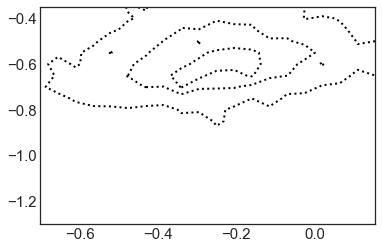

In [652]:
# another way of doing the #plt.pcolormesh(z)
curves = 3
m = max([max(row) for row in z])
levels = np.arange(10, m, (1 / float(curves)) * m)
plt.contour(xedges[:-1], yedges[:-1], z, colors="black", 
              levels=levels, linestyles=ls[f], 
              linewidths=lw[f])

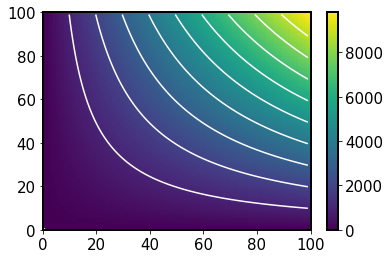

In [530]:
def f(x, y):
  return x*y

xmax = ymax = 100
z = np.array([[f(x, y) for x in range(xmax)] for y in range(ymax)])

plt.pcolormesh(z)
plt.colorbar()
curves = 10
m = max([max(row) for row in z])
levels = np.arange(0, m, (1 / float(curves)) * m)
plt.contour(z, colors="white", levels=levels)
plt.show()

## MacLeod+2010 Fig.14 : using Chelsea's results '<a id='ChelseaFig14'></a>
[contents](#contents)

Use Chelsea's data first.  Structure Function parameters are normalized to a fixed rest wavelength of 4000 Angstroms using 

   $\log_{10}(f(\lambda_{RF})) = A + B \log_{10}{(\lambda_{RF} / 4000)}$   ** (1)**
   
and 

   $\log_{10}(f(4000) = A + B \log_{10}{(1)} = A $        ** (2)**
       
 so subtracting (2) from (1) : 
 
 $\log_{10}(f(\lambda_{RF})  - \log_{10}(f(4000) =  B \log_{10}{(\lambda_{RF} / 4000)}$ , i.e.  we loose the A coefficient ( that's probably why its not listed in the paper) .
 
 Thus : 
 
 $\log_{10}(f(4000) = \log_{10}(f(\lambda_{RF})  - B \log_{10}{(\lambda_{RF} / 4000)}$


or 

$f(4000) / f(\lambda_{RF}) = (4000 / \lambda_{RF})^{B} $

so 

$f(4000) = f(\lambda_{RF}) * (4000 / \lambda_{RF})^{B}$


( i.e. what I derived in my notebook ) 

with $B=-0.479$ and $0.17$ for $SF_{\infty}$ and $\tau$, respectively. 

--> but how do I shift  $\tau(\lambda_{RF})$ and $SF_{\infty}$ to 4000 angstroms ? 

In [6]:
# combine Chelsea's ugriz values, as read-in for reproducing her Fig.13 ... 
s82c = vstack([s82['u'],s82['g'], s82['r'], s82['i'],s82['z']])

In [5]:
# This contains Chelsea's catalog + Shen2011 crossmatch
s82c[:5]

SDR5ID,ra,dec,redshift,M_i,mass_BH,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,lambdaRF,SFinf,tauRF,SFinf4000,tau4000,d2d_asec_DR7,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,float64
301,2.169302,1.238649,1.073,-23.901,0.0,0.968284,1.9955,-0.723982,1.53265,3.72459,-1.23257,-0.584464,0,94.7333,90.6945,92.8552,20.7869,60,1698.02219006,0.0983154039101,47.7420098345,0.0652195355955,55.2281537222,0.0149486190641,000840.63+011419.1,2.16930603981,1.23864996433,1.07369995117,45.5278142511,7.52333061063,1.52309297173,-0.0958869046448,-24.2856077397
144,1.091028,0.962126,0.7867,-23.399,0.0,1.14117,2.27673,-0.325921,2.08917,4.02532,-0.510504,-0.261182,0,63.9319,42.5078,62.2803,20.7824,47,1970.1124979,0.339858055115,105.846953494,0.242087314852,119.389212258,0.00816000678611,000421.84+005743.6,1.09102904797,0.962123990059,0.792900025845,45.4214724626,8.8179503392,0.167266777127,-1.49684842169,-23.9642128907
58,0.331289,0.17723,1.6199,-24.735,0.0,1.23288,1.87484,-0.31862,1.62701,3.0311,-0.636571,-0.236789,0,72.3127,61.8195,69.3966,20.5453,53,1343.5627314,0.21759733284,28.6124657041,0.129033473779,34.4430524005,0.00718657465285,000119.50+001038.0,0.331288993359,0.17722800374,1.6209000349,45.9522119138,8.92171816669,0.204242161504,-1.069876798,-25.0089606857
190,1.364696,-0.098956,0.6125,-23.121,0.0,1.0239,2.47534,-0.394771,2.32222,4.21751,-0.522501,-0.354452,0,99.8258,56.6434,98.5452,19.8859,57,2182.94573643,0.364546193476,185.285006337,0.272751658637,205.377647722,0.0108218821638,000527.52-000556.2,1.36469900608,-0.0989559963346,0.612399995327,45.3939103924,9.02221107204,0.267494722292,-1.72867122474,-24.0391556866
36,0.221552,-0.292485,2.7563,-26.451,9.361,1.10691,1.70714,-0.521248,1.28728,3.6222,-1.09609,-0.386069,0,81.792,78.9905,79.9715,20.6848,55,937.092351516,0.112505969838,13.5637485397,0.0561400245576,17.3590886652,0.0230507646685,000053.17-001732.9,0.221555992961,-0.292490005493,2.75710010529,46.7892839269,9.24939533744,0.0576616388518,-0.56048195562,-26.916981369


In [7]:
s82c.write('ChelseaDRWugrizShen2011.ascii', format='ascii')

In [6]:
# select a good subset of the original table - only what Chelsea 
# considers a 'good' subsample
m2 = s82c['Plike'] - s82c['Pnoise'] > 2 
m3 = s82c['Plike'] - s82c['Pinf'] > 0.05 
m4 = s82c['edge'] == 0 

# choose those that have MBH   from Shen+2007
#m5 = s82c['mass_BH'] > 0 

# or those that have mass from Shen+2011 
m5 = s82c['LOGBH'] > 0 

m = m2*m3*m4*m5
print(len(s82c))
print(np.sum(m))

33218
32936


In [976]:
#s82c['MI_Z2', 'M_i']

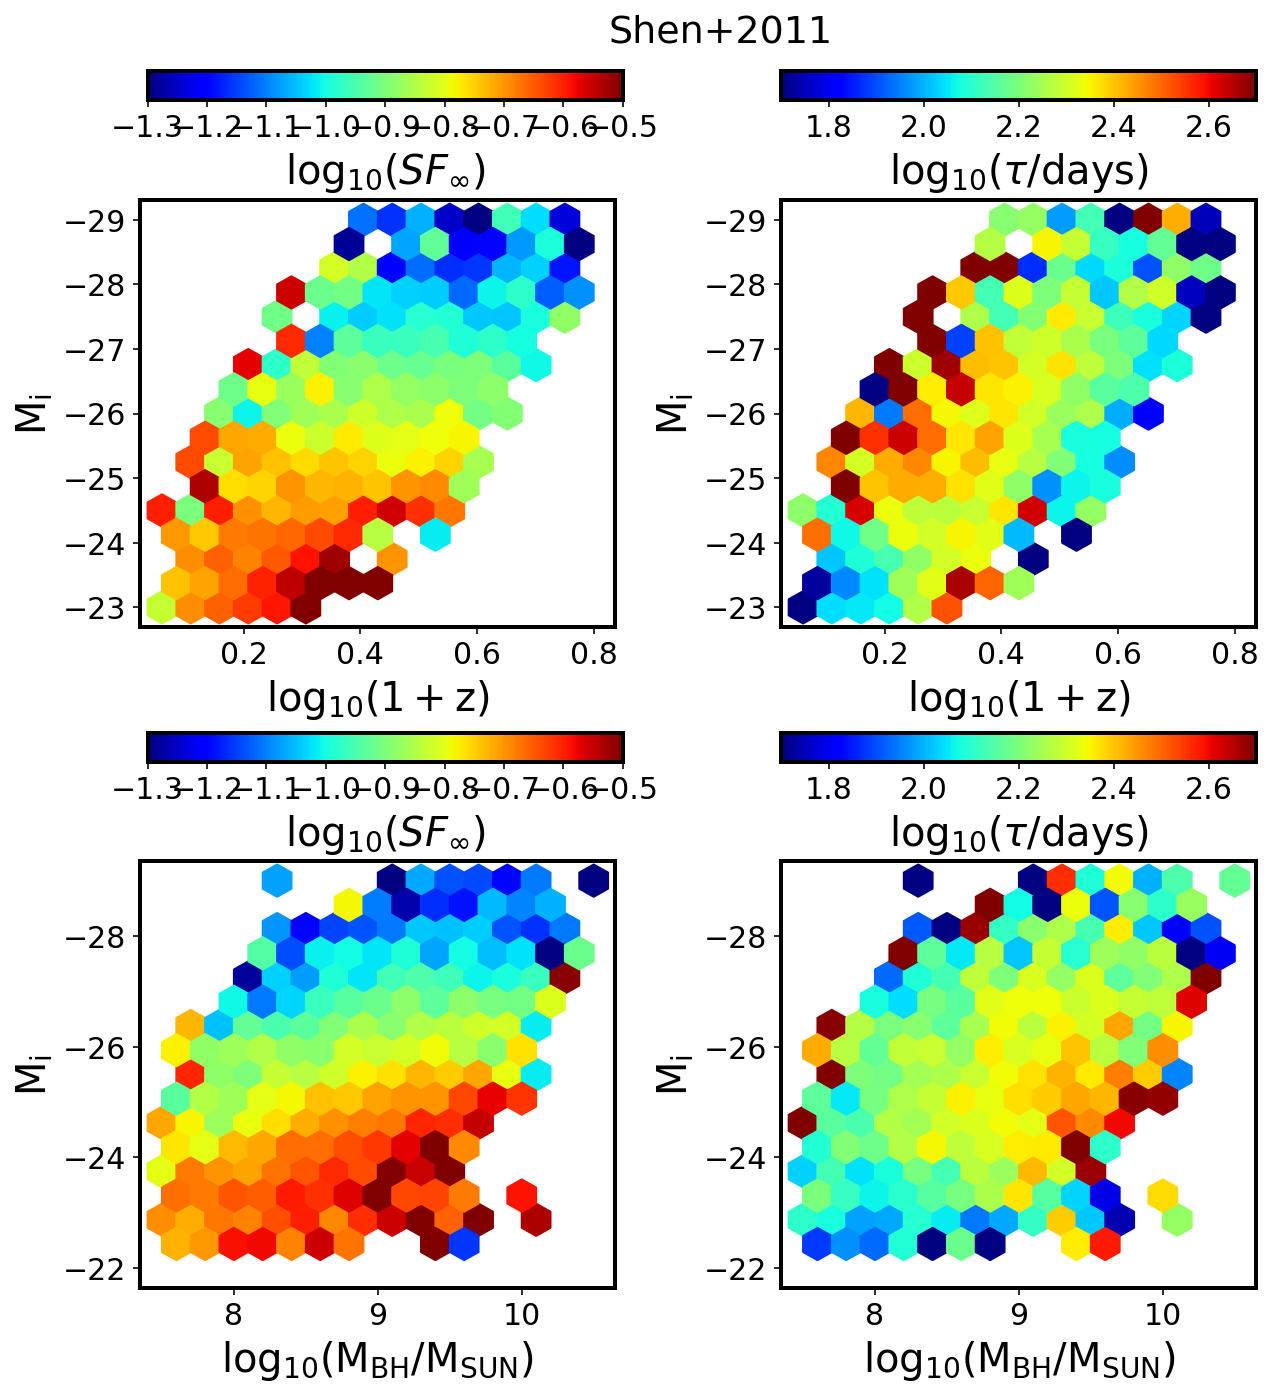

In [9]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
# Make figure like Fig.14 using Chelsea's results ...
fig,axs = plt.subplots(2,2, figsize=(10,10))
ax = np.ravel(axs)
cmap = 'jet'# 'viridis'
# upper left 

#lambdaobs = 6250 # 
#qso_s82drw_['lambdaRF'] = lambdaobs /  (1+ qso_s82drw_['redshift_1'])
#tau_rf = np.power(10,qso_s82drw_['log10tau'])  / (1+ qso_s82drw_['redshift_1'])
#tau_4000 = tau_rf  * np.power(4000 / qso_s82drw_['lambdaRF'] , 0.17)

#sf_rf = qso_s82drw_['SFinf'] #/ (1+ qso_s82drw_['redshift_1'])
#sf_4000 = sf_rf  * np.power(4000 / qso_s82drw_['lambdaRF'] , -0.479)

gridsize=15

# plotted quantities : 
# absolute i-band magnitude 
Mi = s82c['MI_Z2'][m] # s82c['M_i'][m]

# redshift
z = s82c['REDSHIFT'][m] # s82c['redshift'][m]  

# black hole mass from Shen+2008 (Chelsea's catalog)
MBH = s82c['LOGBH'][m] # s82c['mass_BH'][m]

# tau corrected to 4000 A 
tau = s82c['tau4000'][m]

# sf inf corrected to 4000 A 
sf = s82c['SFinf4000'][m]

# upper left 
image = ax[0].hexbin(np.log10(1.+z), Mi, np.log10(sf),
            extent = [0.06,0.8, -23,-29], cmap=cmap, vmin=-1.3, vmax = -0.5,
            gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{\mathrm{(1+z)}}$')
left, bottom, width, height = 0.13, 0.95, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(SF_{\infty})}$')

fig.subplots_adjust(hspace=0.4)

# upper right 
image = ax[1].hexbin(np.log10(1+z), Mi, np.log10(tau),
            extent = [0.06,0.8, -23,-29], cmap=cmap, vmin=1.7, vmax = 2.7,
                           gridsize=gridsize)
ax[1].invert_yaxis()
ax[1].set_xlabel(r'$\log_{10}{\mathrm{(1+z)}}$')

left, bottom, width, height = 0.57, 0.95, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(\tau/\mathrm{days})}$')



# lower left 
image = ax[2].hexbin(MBH,Mi, np.log10(sf),
            extent = [7.5,10.5, -22,-29],  cmap=cmap,
                    gridsize=gridsize, 
                     vmin = -1.3, vmax =-0.5, )
ax[2].invert_yaxis() 
ax[2].set_xlabel(r'$\log_{10}{\mathrm{(M_{BH} / M_{SUN})}}$')
left, bottom, width, height = 0.13, 0.49, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(SF_{\infty})}$')

# lower right 
image = ax[3].hexbin(MBH,Mi, np.log10(tau), vmin = 1.7, vmax=2.7,
            extent = [7.5,10.5, -22,-29],  cmap=cmap, 
                    gridsize=gridsize, 
                    ) # vmin = 0.6, vmax =3., 
ax[3].invert_yaxis() 
ax[3].set_xlabel(r'$\log_{10}{\mathrm{(M_{BH} / M_{SUN})}}$')
left, bottom, width, height = 0.57, 0.49, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(\tau/\mathrm{days})}$')

for i in range(len(ax)):
    ax[i].set_ylabel(r'$\mathrm{M_{i}}$')

fig.subplots_adjust(wspace=0.35 , hspace=0.55)
fig.text(0.45,0.99,'Shen+2011', fontsize=19)
plt.savefig('macleod2010_Fig14_Shen2011.png', bbox_inches='tight')


So the above is the equivalent of Fig.14 in MacLeod+2010, using her data, corrected for $\lambda_{RF}$ dependence, using all ugriz bands. 

Illustrate the main dependencies : just make a scatter plot :
        
   * SFinf vs   MBH ,  SFinf vs Mi 
   * tau vs MBH 

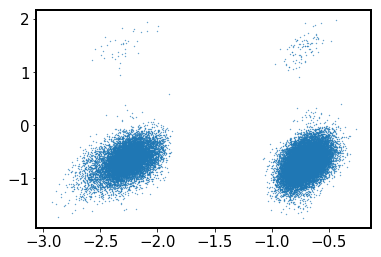

In [9]:
%matplotlib inline
# SFinf 
A = -0.51
B = -0.479# irrelevant if I use the already corrected version of SFinf  , tau 
C = 0.131
D = 0.18

# select a good subset of the original table - only what Chelsea 
# considers a 'good' subsample
m2 = s82c['Plike'] - s82c['Pnoise'] > 2 
m3 = s82c['Plike'] - s82c['Pinf'] > 0.05 
m4 = s82c['edge'] == 0 

# choose those that have MBH   from Shen+2007
#m5 = s82c['mass_BH'] > 0 
# or those that have mass from Shen+2011 
m5 = s82c['LOGBH'] > 0 

m = m2*m3*m4*m5


x = A  + B * np.log10(s82c['lambdaRF'][m] / 4000) + C*(s82c['M_i'][m] + 23) + \
D*(s82c['mass_BH'][m]-9)
y =  np.log10(s82c['SFinf'][m])
plt.scatter(x,y, s=0.1)

In [39]:
s82c[:4]

SDR5ID,ra,dec,redshift,M_i,mass_BH,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,lambdaRF,SFinf,tauRF,SFinf4000,tau4000,d2d_asec_DR7,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,float64
301,2.169302,1.238649,1.073,-23.901,0.0,0.968284,1.9955,-0.723982,1.53265,3.72459,-1.23257,-0.584464,0,94.7333,90.6945,92.8552,20.7869,60,1698.02219006,0.0983154039101,47.7420098345,0.0652195355955,55.2281537222,0.0149486190641,000840.63+011419.1,2.16930603981,1.23864996433,1.07369995117,45.5278142511,7.52333061063,1.52309297173,-0.0958869046448,-24.2856077397
144,1.091028,0.962126,0.7867,-23.399,0.0,1.14117,2.27673,-0.325921,2.08917,4.02532,-0.510504,-0.261182,0,63.9319,42.5078,62.2803,20.7824,47,1970.1124979,0.339858055115,105.846953494,0.242087314852,119.389212258,0.00816000678611,000421.84+005743.6,1.09102904797,0.962123990059,0.792900025845,45.4214724626,8.8179503392,0.167266777127,-1.49684842169,-23.9642128907
58,0.331289,0.17723,1.6199,-24.735,0.0,1.23288,1.87484,-0.31862,1.62701,3.0311,-0.636571,-0.236789,0,72.3127,61.8195,69.3966,20.5453,53,1343.5627314,0.21759733284,28.6124657041,0.129033473779,34.4430524005,0.00718657465285,000119.50+001038.0,0.331288993359,0.17722800374,1.6209000349,45.9522119138,8.92171816669,0.204242161504,-1.069876798,-25.0089606857
190,1.364696,-0.098956,0.6125,-23.121,0.0,1.0239,2.47534,-0.394771,2.32222,4.21751,-0.522501,-0.354452,0,99.8258,56.6434,98.5452,19.8859,57,2182.94573643,0.364546193476,185.285006337,0.272751658637,205.377647722,0.0108218821638,000527.52-000556.2,1.36469900608,-0.0989559963346,0.612399995327,45.3939103924,9.02221107204,0.267494722292,-1.72867122474,-24.0391556866


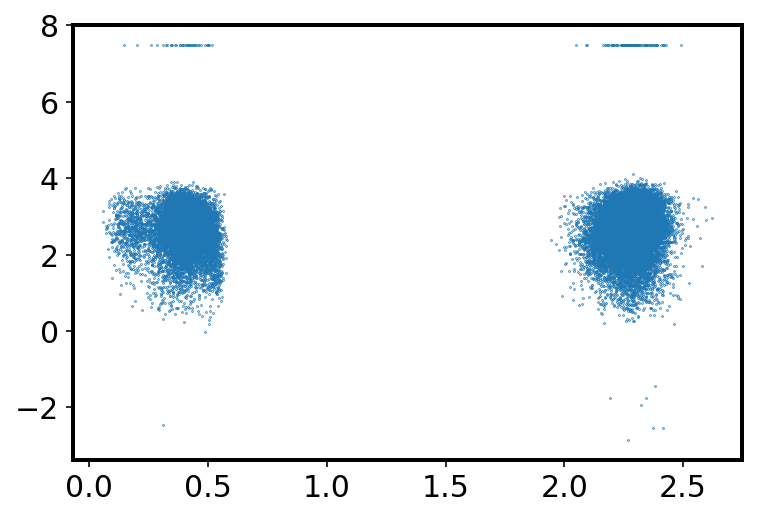

In [45]:
%matplotlib inline
# tau
A = 2.4
B = 0.17 # irrelevant if I use the already corrected version of SFinf  , tau 
C = 0.03
D = 0.21
x = A  + B * np.log10(s82c['lambdaRF'][m] / 4000) + C*(s82c['M_i'][m] + 23) + \
D*(s82c['mass_BH'][m]-9)
y =  s82c['log10tau'][m]
plt.scatter(x,y, s=0.1)

I don't understand why when plotting eq. 7, when using all the appropriate coefficients, etc. I get these two blobs ... 

Plot the three main relations claimed in the paper .... 
* controlling variable for tau is MBH 
* for SFinf, anti-correlation with luminosity clearly dominates any trend with redshift 
* positive correlation between SFinf and MBH is apparent independent of the correlation with Mi 

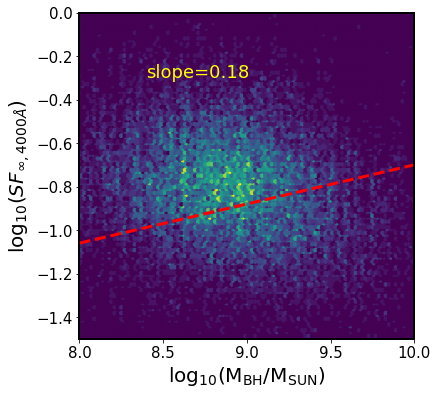

In [20]:
x = s82c['mass_BH'][m]
y = np.log10(s82c['SFinf4000'][m])
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.hexbin(x,y,extent = [8,10,-1.5,0])
x1 = np.linspace(8,10)
# the slope is the D coefficient for SFinf  ...  (Table 1) 
slope=0.18
ax.plot(x1, slope*x1 - 2.5 , lw=3, c='r', ls='--')
ax.text(0.2,0.8, 'slope='+str(slope), 
        transform=ax.transAxes, color='yellow', fontsize=18)
ax.set_xlabel(r'$\log_{10}{\mathrm{(M_{BH} / M_{SUN})}}$')
ax.set_ylabel(r'$\log_{10}{(SF_{\infty, 4000 \AA})}$')

??? why ??? 

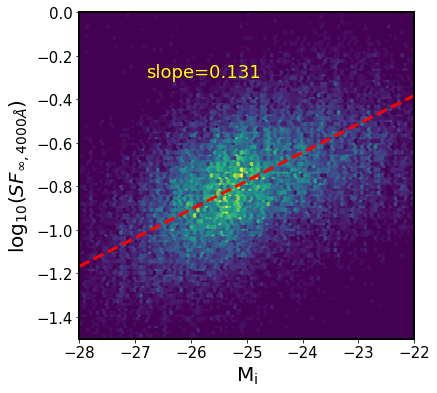

In [17]:
x = s82c['M_i'][m]
y = np.log10(s82c['SFinf4000'][m])
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.hexbin(x,y,extent = [-28,-22,-1.5,0])
x1 = np.linspace(-28,-22)
# the slope is C coefficient for SF (Table 1 )
slope= 0.131
ax.plot(x1, slope*x1 + 2.5 , lw=3, c='r', ls='--')
ax.set_ylabel(r'$\log_{10}{(SF_{\infty, 4000 \AA})}$')
ax.set_xlabel(r'$\mathrm{M_{i}}$')
ax.text(0.2,0.8, 'slope='+str(slope), 
        transform=ax.transAxes, color='yellow', fontsize=18)

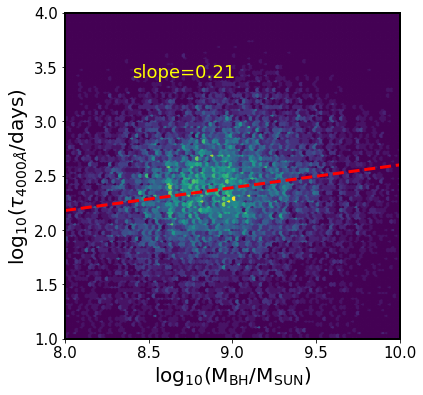

In [18]:
x = s82c['mass_BH'][m]
y = np.log10(s82c['tau4000'][m])
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.hexbin(x,y,extent = [8,10,1,4])
x1 = np.linspace(8,10)
# the slope is the D coefficient for tau  ...  (Table 1) 
slope = 0.21
ax.plot(x1, slope*x1 + 0.5 , lw=3, c='r', ls='--')
ax.set_ylabel(r'$\log_{10}{(\tau_{4000 \AA}/\mathrm{days})}$')
ax.set_xlabel(r'$\log_{10}{\mathrm{(M_{BH} / M_{SUN})}}$')
ax.text(0.2,0.8, 'slope='+str(slope), 
        transform=ax.transAxes, color='yellow', fontsize=18)

Overplot on top of each the line that is supposedly the slope... Why don't I see more clearly in the data that indeed MBH is the controlling variable for tau?   

## Fig.14 with Celerite ...  <a id='celeriteFig14'></a>
[contents](#contents)

Let's use my data for the same QSOs that Chelsea considers to have good data for... ... Also , correct for $\lambda_{RF}$ dependence using Chelsea's coefficients (exponents of -0.479 and 0.17 for $SF_{\infty}$ and $\tau$, respectively) . 

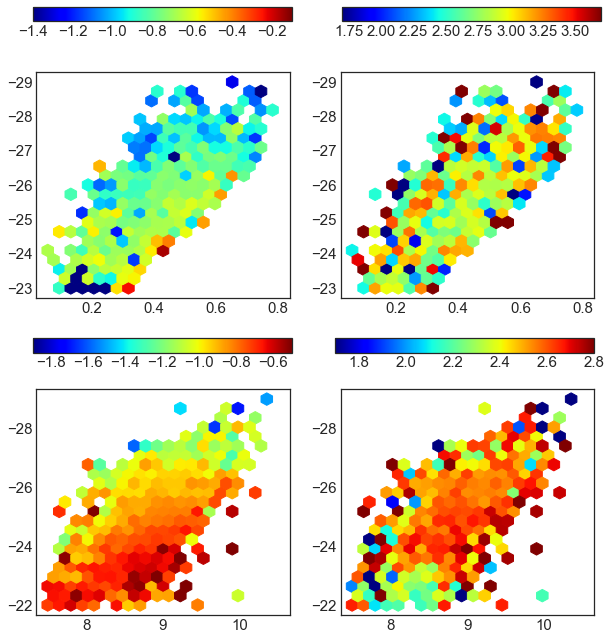

In [597]:
# Make figure like Fig.14 using Celerite  results ...

fig,axs = plt.subplots(2,2, figsize=(10,10))
ax = np.ravel(axs)

# upper left 

lambdaobs = 6250 # 
qso_s82drw_['lambdaRF'] = lambdaobs /  (1+ qso_s82drw_['redshift_1'])

gridsize=20
seg = 'sdss'  # sdss-ps1

#tau_rf = np.power(10,qso['log10tau'])  / (1+ qso['redshift_1'])
tau_rf = qso_s82drw_['tauEXP_'+seg] / (1+ qso_s82drw_['redshift_1'])
tau_4000 = tau_rf  * np.power(4000 / qso_s82drw_['lambdaRF'] , 0.17)



#sf_rf = qso['SFinf'] / (1+ qso['redshift_1'])
sf_rf = np.sqrt(2) * qso_s82drw_['sigmaEXP_'+seg]
sf_4000 = sf_rf  * np.power(4000 / qso_s82drw_['lambdaRF'] , -0.479)



# upper left 
image = ax[0].hexbin(np.log10(1+qso_s82drw_['redshift_1']), 
                     qso_s82drw_['M_i_1'], 
                     np.log10(qso_s82drw_['SFinf']),
            extent = [0.06,0.8, -23,-29], cmap='jet', vmin=-1.4, vmax = -0.1,
                     
                    gridsize=gridsize)
ax[0].invert_yaxis()

left, bottom, width, height = 0.12, 0.95, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal')

fig.subplots_adjust(hspace=0.4)

# upper right 
image = ax[1].hexbin(np.log10(1+qso_s82drw_['redshift_1']), 
                     qso_s82drw_['M_i_1'], 
                     np.log10(tau_l0),
            extent = [0.06,0.8, -23,-29], cmap='jet', vmin=1.7, vmax = 3.7,
                           gridsize=gridsize)
ax[1].invert_yaxis()

left, bottom, width, height = 0.55, 0.95, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal')



# lower left 
image = ax[2].hexbin(qso_s82drw_['mass_BH_1'],
                     qso_s82drw_['M_i_1'], np.log10(sf_4000),
            extent = [7.5,10.5, -22,-29],  cmap='jet',
                    gridsize=gridsize, 
                     vmin = -1.9, vmax =-0.5, )
ax[2].invert_yaxis() 
left, bottom, width, height = 0.12, 0.49, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal')



# lower right 
image = ax[3].hexbin(qso_s82drw_['mass_BH_1'],
                     qso_s82drw_['M_i_1'], np.log10(tau_4000), vmin = 1.7, vmax=2.8,
            extent = [7.5,10.5, -22,-29],  cmap='jet', 
                    gridsize=gridsize, 
                    ) # vmin = 0.6, vmax =3., 
ax[3].invert_yaxis() 
left, bottom, width, height = 0.54, 0.49, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal')







Qualitatively similar results as when using  Chelsea's data... 

## Fig. 15 with Chelsea's results
[contents](#contents)


Make Fig.15 using Chelsea data , get the Lbol ,  LEdd  from Shen+2011 catalog ....  

In [598]:
qso_s82drw_[:3]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ptf,sigmaEXP_sdss-ps1-ptf,sigmaMAP_sdss-ps1-ptf,tauEXP_sdss-ps1-ptf,tauMAP_sdss-ps1-ptf,length_sdss-ps1-ptf-crts,sigmaEXP_sdss-ps1-ptf-crts,sigmaMAP_sdss-ps1-ptf-crts,tauEXP_sdss-ps1-ptf-crts,tauMAP_sdss-ps1-ptf-crts,dbID,ra_1,dec_1,SDR5ID_1,M_i_1,M_i_corr,redshift_1,mass_BH_1,Lbol,u,g,r,i,z,Au,d2d_arcsec_DR7,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGEDD_RATIO,d2d_arcsec_chelsea,SDR5ID_2,ra_2,dec_2,redshift_2,M_i_2,mass_BH_2,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,SFinf,lambdaRF
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64
233.txt,3321.033842,0.112765414555,0.0898995121063,981.875197365,270.133423745,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.115511511771,0.113080341967,17.7186414587,12.1535796268,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,0.00718657465285,000119.50+001038.0,0.331288993359,0.17722800374,1.6209000349,45.9522119138,8.92171816669,-1.069876798,0.0,58,0.331289,0.17723,1.6199,-24.735,0.0,1.19407,2.44022,-0.848145,2.24434,4.1202,-1.02269,-0.781607,0,134.36,107.71,132.865,20.3141,57,0.123258979507,2385.58723615
1018.txt,3336.933302,0.219967338358,0.166799870973,1005.98831672,331.440202397,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.208861039395,0.205851702862,1.12644722505,1.0,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,0.0108218821638,000527.52-000556.2,1.36469900608,-0.0989559963346,0.612399995327,45.3939103924,9.02221107204,-1.72867122474,0.0,190,1.364696,-0.098956,0.6125,-23.121,0.0,1.12426,2.87294,-0.627733,2.72995,4.49924,-0.719803,-0.591494,0,152.593,82.2158,152.094,19.4742,62,0.336969480031,3875.96899225
1327.txt,3336.933324,0.10176772487,0.0824972045393,567.610084936,215.218303228,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5865.0169872,0.137629240634,0.13302700692,22.3107288091,17.5193899944,1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139,0.0210127501153,000107.52+004113.1,0.281367003918,0.68698900938,1.39900004864,46.0356964494,8.77970169839,-0.844375794117,0.0,49,0.28137,0.686984,1.3988,-24.917,8.817,0.870333,2.5301,-0.832748,2.3953,4.21627,-0.94041,-0.795638,0,175.03,103.201,173.65,19.72,63,0.14163010195,2605.46940137


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


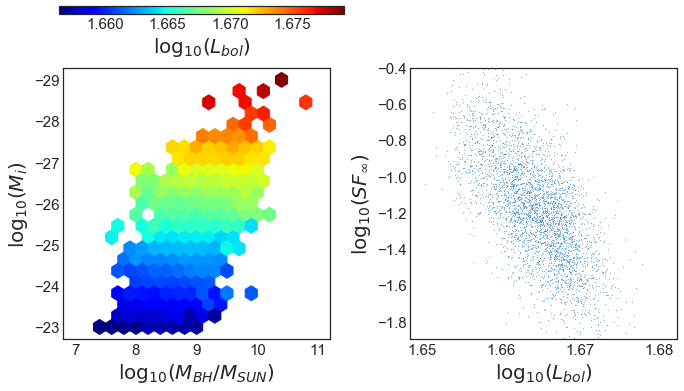

In [599]:

fig,axs = plt.subplots(1,2, figsize=(11,5))
ax = np.ravel(axs)

lambdaobs = 6250 #
qso_s82drw_['lambdaRF'] = lambdaobs /  (1+ qso_s82drw_['redshift_1'])

sf_rf = qso_s82drw_['SFinf'] / (1+ qso_s82drw_['redshift_1'])
sf_4000 = sf_rf  * np.power(4000 / qso_s82drw_['lambdaRF'] , -0.479)

gridsize=20

# select only those that have bolometric luminosity estimate ... 
#m = qso_s82drw_['Lbol'] > 0


# left panel 
image = ax[0].hexbin(qso_s82drw_['mass_BH_1'], 
                     qso_s82drw_['M_i_1'], 
                     np.log10(qso_s82drw_['Lbol']),
            extent = [7,11, -23,-29], cmap='jet',
             gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{(M_{BH}/M_{SUN})}$')
ax[0].set_ylabel(r'$\log_{10}{(M_{i})}$')


left, bottom, width, height = 0.12, 1.03, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(L_{bol})}$')

# right panel 

ax[1].scatter(np.log10(qso_s82drw_['Lbol']), np.log10(sf_4000), s=0.05)
ax[1].set_ylim(-1.9,-0.4)
#ax[1].set_xlim(-2.5,0.5)
ax[1].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[1].set_xlabel(r'$\log_{10}{(L_{bol})}$')
fig.subplots_adjust(wspace=0.3)

The left panel is obvious because  absolute i-band magnitude $M_{i}$ is a proxy for $L_{Bol}$. But to compare with Chelsea's plot,  

$L_{Edd} = \frac{4 \pi GM c }{\kappa }$

$\kappa  =  \sigma_{T} / m_{P},  $

use eq. (2.76) in Bradt 'Astrophysical Processes' to get the equation with all the values filled in to get : 


$L_{Edd} / L_{Sun} = 3.27 \cdot 10^{4}  \mu_{e} M_{BH} / M_{Sun}$

with $\mu_{e} \approx 1 $ for totally ionized hydrogen, 
 
Also, check Shen+2011 , since it was published after MacLeod+2010,  for more up-to-date SMBH masses .... 

 

thus, if they used the above equation,  the log of Eddington ratio should follow the following with respect to the Black Hole Mass : 

In [604]:
qso_s82drw_[:3]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,length_sdss-ps1-ptf,sigmaEXP_sdss-ps1-ptf,sigmaMAP_sdss-ps1-ptf,tauEXP_sdss-ps1-ptf,tauMAP_sdss-ps1-ptf,length_sdss-ps1-ptf-crts,sigmaEXP_sdss-ps1-ptf-crts,sigmaMAP_sdss-ps1-ptf-crts,tauEXP_sdss-ps1-ptf-crts,tauMAP_sdss-ps1-ptf-crts,dbID,ra_1,dec_1,SDR5ID_1,M_i_1,M_i_corr,redshift_1,mass_BH_1,Lbol,u,g,r,i,z,Au,d2d_arcsec_DR7,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGEDD_RATIO,d2d_arcsec_chelsea,SDR5ID_2,ra_2,dec_2,redshift_2,M_i_2,mass_BH_2,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,SFinf,lambdaRF
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64
233.txt,3321.033842,0.112765414555,0.0898995121063,981.875197365,270.133423745,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.0899210725326,0.0858301936994,26.7223106075,17.254074259,5505.090184,0.115511511771,0.113080341967,17.7186414587,12.1535796268,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,0.00718657465285,000119.50+001038.0,0.331288993359,0.17722800374,1.6209000349,45.9522119138,8.92171816669,-1.069876798,0.0,58,0.331289,0.17723,1.6199,-24.735,0.0,1.19407,2.44022,-0.848145,2.24434,4.1202,-1.02269,-0.781607,0,134.36,107.71,132.865,20.3141,57,0.123258979507,2385.58723615
1018.txt,3336.933302,0.219967338358,0.166799870973,1005.98831672,331.440202397,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.219634746606,0.211255491825,17.070572564,42.3742446958,5511.071033,0.208861039395,0.205851702862,1.12644722505,1.0,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,0.0108218821638,000527.52-000556.2,1.36469900608,-0.0989559963346,0.612399995327,45.3939103924,9.02221107204,-1.72867122474,0.0,190,1.364696,-0.098956,0.6125,-23.121,0.0,1.12426,2.87294,-0.627733,2.72995,4.49924,-0.719803,-0.591494,0,152.593,82.2158,152.094,19.4742,62,0.336969480031,3875.96899225
1327.txt,3336.933324,0.10176772487,0.0824972045393,567.610084936,215.218303228,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5511.07403,0.142292968904,0.136575302182,15.9205058477,12.4538594935,5865.0169872,0.137629240634,0.13302700692,22.3107288091,17.5193899944,1327,0.28137,0.686984,49,-24.917,-25.288,1.3988,8.817,46.071,20.213,20.105,19.815,19.666,19.749,0.139,0.0210127501153,000107.52+004113.1,0.281367003918,0.68698900938,1.39900004864,46.0356964494,8.77970169839,-0.844375794117,0.0,49,0.28137,0.686984,1.3988,-24.917,8.817,0.870333,2.5301,-0.832748,2.3953,4.21627,-0.94041,-0.795638,0,175.03,103.201,173.65,19.72,63,0.14163010195,2605.46940137


I think I should use Shen+2011 values : see what it gives ... 

Now do really Chelsea's Fig.15 and use Shen+2011 for the Eddington ratio and BH Mass ...

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


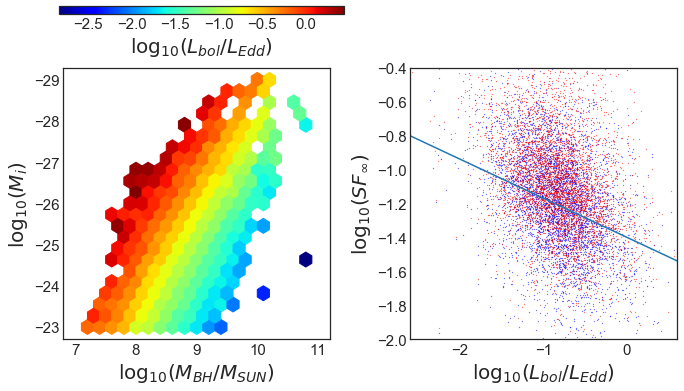

In [897]:

fig,axs = plt.subplots(1,2, figsize=(11,5))
ax = np.ravel(axs)

lambdaobs = 6250 #
qso_s82drw_['lambdaRF'] = lambdaobs /  (1+ qso_s82drw_['redshift_1'])

#Chelsea's 
qso_s82drw_['SFinfRF'] =  qso_s82drw_['SFinf'] / (1+ qso_s82drw_['redshift_1'])
qso_s82drw_['SFinf4000'] = qso_s82drw_['SFinfRF'] *\
             np.power(4000 / qso_s82drw_['lambdaRF'] , -0.479)

# Celerite 
sfinf = qso_s82drw_['sigmaEXP_sdss-ps1'] * np.sqrt(2)
qso_s82drw_['SFinfEXP_sdss-ps1_RF'] = sfinf / (1 + qso_s82drw_['redshift_1'])
qso_s82drw_['SFinfEXP_sdss-ps1_4000'] = qso_s82drw_['SFinfEXP_sdss-ps1_RF'] *\
             np.power(4000 / qso_s82drw_['lambdaRF'] , -0.479)

    
gridsize=20

# select only those that have bolometric luminosity estimate ... 
# m = qso['Lbol'] > 0


# left panel 
image = ax[0].hexbin(qso_s82drw_['LOGBH'], 
                     qso_s82drw_['M_i_1'], 
                     qso_s82drw_['LOGEDD_RATIO'],
            extent = [7,11, -23,-29], cmap='jet',
             gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{(M_{BH}/M_{SUN})}$')
ax[0].set_ylabel(r'$\log_{10}{(M_{i})}$')


left, bottom, width, height = 0.12, 1.03, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')

# right panel

ax[1].scatter(qso_s82drw_['LOGEDD_RATIO'], np.log10(qso_s82drw_['SFinf4000']), 
              s=0.05, c='blue')
ax[1].scatter(qso_s82drw_['LOGEDD_RATIO'], np.log10(qso_s82drw_['SFinfEXP_sdss-ps1_4000']), 
              s=0.05, c='red')

ax[1].set_ylim(-2,-0.4)
ax[1].set_xlim(-2.6,0.6)
ax[1].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[1].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')


# plot Chelsea's slope...
x = np.linspace(-2.6,0.6)
ax[1].plot(x, -0.23*x - 1.4)

fig.subplots_adjust(wspace=0.3)
plt.savefig('macleod2010_Fig15.png', bbox_inches='tight')

The red points (Chelsea's) and blue points (Celerite EXP sigma-based SF)  seem to come from very similar (if not identical) distributions. ... 

Summary : 
    - my code works, and I can reproduce Chelsea's figures with her data 
    - there is some difference between Shen+2008 (used by Chelsea) and Shen+2011 when it comes to BH mass, and LBol (and thus  Eddington ratio) . This would affect the calculated slopes and relations  ( such as eq.(7) in MacLeod+2010 ) 
    
    - the main thing to do, apart from showing the ratios of sigma_SDSS+PS1/ sigma_SDSS,  would be to consider Fig,14,15 with Celerite ,  albeit I cannot derive wavelength correction factors to be able to shift rest-frame SFinf, and tau,  to 4000 Angstroms...  I could use hers ,  and derive eq. (7) coefficients ... 